### ref
- ゼロから作るDeep Learning
- pytorch.org

# パーセプトロン・活性化関数・誤差関数・誤差逆伝播
## パーセプトロン
パーセプトロンはニューラルネットワークの元となったモデルで、入力と出力のみからなるモデルです。
このパーセプトロンはNANDすら解けない程度でした。パーセプトロンの関数としての問題は、**線形**であったことです。
> 線形関数は、
   - $c f(x) = f(cx)$ c: 定数
   - $f(x) + f(y) = f(x + y)$   
が成り立つような関数です。

線形だと下のセルにある図1のような問題を解けません。図1にあるような問題を線形分離不可能と言います。
このような問題は複数の直線か曲線でないと分離できません。一方、
線形分離可能な問題というのはクラスタを直線で分離できるようなものです（fig 2.）。
![fig 1](./images/fig_01.png)
![fig 2](./images/fig_02.png)

## 活性化関数
ニューラルネットワークは非線形な関数ですが、シンプルには線形な関数を非線形にするために活性化関数を用います。
活性化関数を適用する位置はスライド参照。  
活性化関数はニューロンの発火にインスパイアされたもので、初めはステップ関数が使われていましたが、誤差を用いたパラメータ更新（学習）のことを
考えて、微分可能な`sigmoid`関数が用いられるようになりました。現在では`ReLU`やその派生が主流になっています。
`ReLU`が主流になっている理由としては、計算が速いことと微分が楽なことが挙げられます。  
ほとんどの問題で、「線形変換によってデータの次元数を減らし、活性化関数を適用する」と言う処理を繰り返して出力します。
![fig 3](./images/fig_03.png)
![fig 4](./images/fig_04.png)
![fig 5](./images/fig_05.png)
![fig 6](./images/fig_06.png)

## 誤差関数
誤差関数は各タスクに合わせて設計されます。回帰問題では二乗誤差、識別問題では交差エントロピー（sigmoid cross entropy、softmax cross entropy）
が主流です。  
モデルの出力を$\hat{\boldsymbol{y}}$、正解を$\boldsymbol{y}$とすると、
二乗誤差は、$|| \boldsymbol{y} - \hat{\boldsymbol{y}}||^2$、交差エントロピーは$ - \boldsymbol{y}\cdot \log \hat{\boldsymbol{y}}$
で計算できます。
表記に関しては誤差の値自体は$\bf{E}$、誤差関数は$L(\hat{\boldsymbol{y}}, \boldsymbol{y}), \ L$と表すことが多いです。

![fig 7](./images/fig_07.png)

普通、誤差は小さいほど良いです。　ただし、前回（4/16）に伝えた通り誤差は2種類あります。前回は図をお見せすることが
できませんでしたが、下の図（青が訓練誤差、オレンジが汎化誤差を表す）[^1]では実際に初めは2つの誤差が
順調に下がっていますが10epochあたりを境に汎化誤差は上がり始めています。そのため、このモデルは100epoch学習したもの
よりも10epochあたりのものの方が道のデータに対して精度が高いと想像できます。

![overfitting](https://github.com/mitmul/chainer-handson/blob/master/DeepCNN_cifar10_result/loss.png?raw=true)

[^1]: image from https://github.com/mitmul/chainer-handson

## 誤差逆伝播
偏微分・連鎖律がベースになっています。実際に扱う場合はフレームワークがよしなにやってくれているので特に説明しません。
この誤差逆伝播で各レイヤーに誤差を渡し、その誤差を用いてパラメータを更新します。

ここでは、PyTorchを用いて（toy dataで）誤差逆伝播をほぼ意識することなく実行できることを
以下のコードを直下のセルにコピペして確認しましょう。`ctrl + b -> cmd + p -> shift + return`

```back_prop_check.py
import torch
from torch.autograd import Variable

x = Variable(torch.ones(2, 2), requires_grad=True)
z = (x + 2) * (x + 2) * 3
print('z: {}'.format(z))
out = z.mean()
print('out: {}'.format(out))
out.backward()
print(x.grad)
```

---

# ニューラルネット
## 学習の流れ

### ミニバッチ
データセットの大きさを$N$とするとデータセットは教師あり学習の場合は$(\boldsymbol{x}_i, \boldsymbol{y}_i)_{i= 1}^N$と表せます。
バッチ処理はデータセットのすべてのデータに対して誤差を計算し、パラメータを更新する方法ですが、$N = 10,000$を超えることがほとんどの場合、
誤差を計算する回数に対してアップデートの回数が少なく、学習に時間がかかります。そのため、一般的には$n = 32$ぐらいのデータ（ミニバッチ）ごとに
アップデートを行い、プログラム中ではミニバッチを1つの変数のように扱います。
データの次元数が$d_{data}$の時、ミニバッチの形はは$n \times d_{data}$になります。

よく、「学習は100epochで1epochは300iteration」などの言い方をしますが、
データセットの大きさを$N$、ミニバッチの大きさを$n$とすると、イテレーション数は$N / n$となり、これが1epochに該当します。

<!--
## 実装
コードを書いていきましょう。
-->

## データの扱い方
ミニバッチを1つの変数として扱うので学習ループ内での各変数の形は`[batch_size, *data_shape]`になります。

## モデルの構造
モデルはレイヤー（線形変換）と活性化関数（非線形）で作られていますが、どちらも関数であることに変わりはないです。しかし、
レイヤーは重みが更新されるので学習するにつれてその出力は変化します。`モデルの構造 1`では箱と箱を結ぶ線が活性化関数を、箱自体がレイヤーを表しています。また、`モデルの構造 2`では活性化関数が省略されています。  
多くのライブラリではレイヤーと活性化関数のファイルのディレクトリが分けられています。

###  レイヤー
- Linear / Dense / Full Connected
- Convolutional
- Recurrent (LSTM)
- Normalisation
    - (Dropout)
    - Batch Normalization
    
### 活性化関数
- tanh
- sigmoid
- relu
    - leaky relu
    - prelu
    - elu
    
## 多層パーセプトロン（Multi Layer Perceptron）
### どんなモデルか
多層パーセプトロンは`Linear~`レイヤーのみからなるニューラルネットワークで、データの行列と重みの行列のかけ算を繰り返して
います。
基本的に、このレイヤーを用いた計算を行う場合、入力として渡せるデータは2次元配列で、axis-0がバッチサイズ、axis-1が
データの特徴量の次元数です。レイヤーの定義をする際に、`Linear`レイヤーに入力するときのデータの特徴量の次元数`in_size`と出力する際のデータの特徴量の次元数`out_size`を指定します。`in_size`はその前のレイヤーの`out_size`、あるいはもともとのデータの特徴量の次元数に揃える必要がありますが、`out_size`は任意の値を指定できます。
自由に設定できるといえど、最終出力の`out_size`は識別タスクならクラス数、回帰問題なら実数を返すなどタスクに
合わせる必要はあります。

![linear](./images/linear_layer.png)

---

ここでは、まず有名な手書き数字データセットのMNISTを用いて多層パーセプトロンの実験を行います。
多層パーセプトロン（スライド参照）を実装しましょう。データセットはスライドにあるリンクからダウンロードしてください。
jupyter notebookではセルの先頭で`%%bash`と宣言することでshellコマンドを実行できるので次の感じでできます。
```python
%%bash
wget 'https:/url/to/data'
unzip mnist.zip
```

MNISTのデータは$0$から$9$の10クラス分類で各データは$28 \times 28$の画像を平らにした$784$次元です。
この$784$次元のデータをいくつかの`Linear`を用いて$10$次元にしましょう。
ここで使えるレイヤーは

- `Linear`: 第1引数：入力データの次元数、第2引数：出力データの次元数
- `BatchNorm1d`: 引数は次元数
- `Dropout`: 引数は変数

で、活性化関数は

- `sigmoid`
- `relu`
- `tanh`

などです。

`import`する必要があるのは、

```mnit_mlp.py
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=custom_data_home)
```

In [35]:
%matplotlib inline
import os  # path
import datetime
import numpy as np  # 行列演算
import matplotlib.pyplot as plt  # グラフ
from tqdm import tqdm  # progress bar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [18]:
# モデルの定義
class SimpleLinear(nn.Module):
    
    def __init__(self, in_dim=784, out_dim=10, hidden_dim=100):
        super(SimpleLinear, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 784)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)
    
    def predict(self, x):
        return nn.Softmax(self.forward(x))

In [19]:
_cuda = False
kwargs = {'num_workers': 1, 'pin_memory': True} if _cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=50, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.ToTensor()),
    batch_size=50, shuffle=True, **kwargs)

Files already downloaded


In [82]:
def train(epoch, log_interval=100):
    model.train()  # モデルがロスを用いて更新するように設定
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()  # モデルのレイヤーが前のエポックでの勾配履歴を保持しているので消去
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.data[0]
        loss.backward()  # 誤差逆伝播
        optimizer.step()  # パラメータを更新
        if batch_idx % log_interval == 0:
            print('Training')
            print('epoch: {} [{}/{} ({:.0f}%)]\tloss:{:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                                                                   100. * batch_idx / len(train_loader), loss.data[0]))
    return train_loss / len(train_loader)

def test(epoch):
    model.eval()  #  更新しないように設定
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data[0]
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    print('Test')
    print('Average loss: {:.4f},\tAccuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, len(test_loader.dataset),
                                                                   100. * correct / len(test_loader.dataset)))
    return test_loss, correct

In [83]:
def run(n_epoch, train, test):
    train_loss = []
    test_loss = []
    test_accuracy = []
    start = datetime.datetime.now()
    print('Training started at {}'.format(start.strftime('%Y-%m-%d, %H:%M')))
    for epoch in range(1, n_epoch + 1):
        if epoch == 1:
            loop_start = datetime.datetime.now()
        train_loss.append(train(epoch))
        t_loss, t_accuracy = test(epoch)
        test_loss.append(t_loss)
        test_accuracy.append(t_accuracy)
        if epoch == 1:
            loop_end = datetime.datetime.now()
            print('one epoch takes {} sec'.format((loop_end - loop_start).total_seconds()))
    end = datetime.datetime.now()
    print('Training finished at {}'.format(end.strftime('%Y-%m-%d, %H:%M')))
    print('Duration: {}'.format((end - start).total_seconds()))
    return train_loss, test_loss, test_accuracy

In [84]:
def plot_results(train_loss, test_loss, test_accuracy, save=False, save_dir='./images/result'):
    time_stamp = datetime.datetime.now().strftime('%Y/%m/%d, %H:%M')
    f_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')
    plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='train loss')
    plt.plot(list(range(1, len(test_loss) + 1)), test_loss, label='test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.title('loss result at {}'.format(time_stamp))
    plt.legend()
    if save:
        tmp_save_dir = os.path.join(save_dir, 'loss')
        f_name = os.path.join(tmp_save_dir, '{}.png'.format(f_time))
        if not os.path.exists(tmp_save_dir):
            os.makedirs(tmp_save_dir)
        print('path to save loss: {}'.format(f_name))
        plt.savefig(f_name)
    plt.show()
    
    plt.plot(list(range(1, len(test_accuracy) + 1)), list(np.asarray(test_accuracy) / 100.0), label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.title('accuracy result at {}'.format(time_stamp))
    plt.legend()
    if save:
        tmp_save_dir = os.path.join(save_dir, 'accuracy')
        f_name = os.path.join(tmp_save_dir, '{}.png'.format(f_time))
        if not os.path.exists(tmp_save_dir):
            os.makedirs(tmp_save_dir)
        print('path to save accuracy: {}'.format(f_name))
        plt.savefig(f_name)
    plt.show()

In [45]:
train_loss = []
test_loss = []
test_correct = []
start = datetime.datetime.now()
for epoch in tqdm(range(1, epoch + 1)):
    if epoch == 1:
        loop_s = datetime.datetime.now()
    train_loss.append(train(epoch))
    t_loss, t_correct = test(epoch)
    test_loss.append(t_loss)
    test_correct.append(t_correct)
    if epoch == 1:
        loop_e = datetime.datetime.now()
        print('1 epoch took {} [sec]'.format((loop_e - loop_s).total_seconds()))
end = datetime.datetime.now()
print('Training finished.')
print('Began at {}'.format(start.strftime('%y, %m/%d, %H:%M')))
print('Finished at {}'.format(end.strftime('%y %m/%d, %H:%M')))
tmp = end - start
print('duration: {} [sec]'.format(tmp.total_seconds()))

  0%|          | 0/100 [00:00<?, ?it/s]

Training
epoch: 1 [0/60000 (0%)]	loss:2.303484
Training
epoch: 1 [5000/60000 (8%)]	loss:0.967243
Training
epoch: 1 [10000/60000 (17%)]	loss:0.834660
Training
epoch: 1 [15000/60000 (25%)]	loss:0.718099
Training
epoch: 1 [20000/60000 (33%)]	loss:0.966535
Training
epoch: 1 [25000/60000 (42%)]	loss:0.717970
Training
epoch: 1 [30000/60000 (50%)]	loss:0.803969
Training
epoch: 1 [35000/60000 (58%)]	loss:1.122537
Training
epoch: 1 [40000/60000 (67%)]	loss:0.330047
Training
epoch: 1 [45000/60000 (75%)]	loss:0.707062
Training
epoch: 1 [50000/60000 (83%)]	loss:0.727253
Training
epoch: 1 [55000/60000 (92%)]	loss:0.544302


  1%|          | 1/100 [00:05<09:07,  5.53s/it]

Test
Average loss: 0.6349,	Accuracy: 7670/10000 (77%)
1 epoch took 5.52525 [sec]
Training
epoch: 2 [0/60000 (0%)]	loss:0.543844
Training
epoch: 2 [5000/60000 (8%)]	loss:0.791588
Training
epoch: 2 [10000/60000 (17%)]	loss:0.482442
Training
epoch: 2 [15000/60000 (25%)]	loss:0.668283
Training
epoch: 2 [20000/60000 (33%)]	loss:0.821018
Training
epoch: 2 [25000/60000 (42%)]	loss:0.651210
Training
epoch: 2 [30000/60000 (50%)]	loss:0.387662
Training
epoch: 2 [35000/60000 (58%)]	loss:0.652570
Training
epoch: 2 [40000/60000 (67%)]	loss:0.292952
Training
epoch: 2 [45000/60000 (75%)]	loss:0.796675
Training
epoch: 2 [50000/60000 (83%)]	loss:0.595370
Training
epoch: 2 [55000/60000 (92%)]	loss:0.488732


  2%|▏         | 2/100 [00:11<09:01,  5.53s/it]

Test
Average loss: 0.5749,	Accuracy: 7800/10000 (78%)
Training
epoch: 3 [0/60000 (0%)]	loss:0.754912
Training
epoch: 3 [5000/60000 (8%)]	loss:0.479785
Training
epoch: 3 [10000/60000 (17%)]	loss:0.640760
Training
epoch: 3 [15000/60000 (25%)]	loss:0.600685
Training
epoch: 3 [20000/60000 (33%)]	loss:0.415416
Training
epoch: 3 [25000/60000 (42%)]	loss:0.574087
Training
epoch: 3 [30000/60000 (50%)]	loss:0.560738
Training
epoch: 3 [35000/60000 (58%)]	loss:0.506050
Training
epoch: 3 [40000/60000 (67%)]	loss:0.646184
Training
epoch: 3 [45000/60000 (75%)]	loss:0.813589
Training
epoch: 3 [50000/60000 (83%)]	loss:0.724715
Training
epoch: 3 [55000/60000 (92%)]	loss:0.682449


  3%|▎         | 3/100 [00:16<09:01,  5.58s/it]

Test
Average loss: 0.5562,	Accuracy: 7833/10000 (78%)
Training
epoch: 4 [0/60000 (0%)]	loss:0.747488
Training
epoch: 4 [5000/60000 (8%)]	loss:0.418994
Training
epoch: 4 [10000/60000 (17%)]	loss:0.458774
Training
epoch: 4 [15000/60000 (25%)]	loss:0.460701
Training
epoch: 4 [20000/60000 (33%)]	loss:0.361577
Training
epoch: 4 [25000/60000 (42%)]	loss:0.454822
Training
epoch: 4 [30000/60000 (50%)]	loss:0.597663
Training
epoch: 4 [35000/60000 (58%)]	loss:0.386661
Training
epoch: 4 [40000/60000 (67%)]	loss:0.473759
Training
epoch: 4 [45000/60000 (75%)]	loss:0.617057
Training
epoch: 4 [50000/60000 (83%)]	loss:0.584388
Training
epoch: 4 [55000/60000 (92%)]	loss:0.505944


  4%|▍         | 4/100 [00:22<09:03,  5.67s/it]

Test
Average loss: 0.5430,	Accuracy: 7867/10000 (79%)
Training
epoch: 5 [0/60000 (0%)]	loss:0.531619
Training
epoch: 5 [5000/60000 (8%)]	loss:0.418966
Training
epoch: 5 [10000/60000 (17%)]	loss:0.525929
Training
epoch: 5 [15000/60000 (25%)]	loss:0.191841
Training
epoch: 5 [20000/60000 (33%)]	loss:0.483811
Training
epoch: 5 [25000/60000 (42%)]	loss:0.712685
Training
epoch: 5 [30000/60000 (50%)]	loss:0.475596
Training
epoch: 5 [35000/60000 (58%)]	loss:0.340011
Training
epoch: 5 [40000/60000 (67%)]	loss:0.648893
Training
epoch: 5 [45000/60000 (75%)]	loss:0.360071
Training
epoch: 5 [50000/60000 (83%)]	loss:0.482588
Training
epoch: 5 [55000/60000 (92%)]	loss:0.222746


  5%|▌         | 5/100 [00:28<09:01,  5.70s/it]

Test
Average loss: 0.5337,	Accuracy: 7877/10000 (79%)
Training
epoch: 6 [0/60000 (0%)]	loss:0.704559
Training
epoch: 6 [5000/60000 (8%)]	loss:0.406416
Training
epoch: 6 [10000/60000 (17%)]	loss:0.423731
Training
epoch: 6 [15000/60000 (25%)]	loss:0.314708
Training
epoch: 6 [20000/60000 (33%)]	loss:0.436385
Training
epoch: 6 [25000/60000 (42%)]	loss:0.663509
Training
epoch: 6 [30000/60000 (50%)]	loss:0.445086
Training
epoch: 6 [35000/60000 (58%)]	loss:0.591515
Training
epoch: 6 [40000/60000 (67%)]	loss:0.316037
Training
epoch: 6 [45000/60000 (75%)]	loss:0.700300
Training
epoch: 6 [50000/60000 (83%)]	loss:0.489143
Training
epoch: 6 [55000/60000 (92%)]	loss:0.387292


  6%|▌         | 6/100 [00:34<08:56,  5.70s/it]

Test
Average loss: 0.5308,	Accuracy: 7887/10000 (79%)
Training
epoch: 7 [0/60000 (0%)]	loss:0.523274
Training
epoch: 7 [5000/60000 (8%)]	loss:0.431212
Training
epoch: 7 [10000/60000 (17%)]	loss:0.385797
Training
epoch: 7 [15000/60000 (25%)]	loss:0.253729
Training
epoch: 7 [20000/60000 (33%)]	loss:0.363231
Training
epoch: 7 [25000/60000 (42%)]	loss:0.493087
Training
epoch: 7 [30000/60000 (50%)]	loss:0.420521
Training
epoch: 7 [35000/60000 (58%)]	loss:0.457433
Training
epoch: 7 [40000/60000 (67%)]	loss:0.743591
Training
epoch: 7 [45000/60000 (75%)]	loss:0.640478
Training
epoch: 7 [50000/60000 (83%)]	loss:0.519614
Training
epoch: 7 [55000/60000 (92%)]	loss:0.596402


  7%|▋         | 7/100 [00:39<08:51,  5.71s/it]

Test
Average loss: 0.5262,	Accuracy: 7901/10000 (79%)
Training
epoch: 8 [0/60000 (0%)]	loss:0.712457
Training
epoch: 8 [5000/60000 (8%)]	loss:0.361477
Training
epoch: 8 [10000/60000 (17%)]	loss:0.431710
Training
epoch: 8 [15000/60000 (25%)]	loss:0.494976
Training
epoch: 8 [20000/60000 (33%)]	loss:0.341166
Training
epoch: 8 [25000/60000 (42%)]	loss:0.610359
Training
epoch: 8 [30000/60000 (50%)]	loss:0.379629
Training
epoch: 8 [35000/60000 (58%)]	loss:0.466459
Training
epoch: 8 [40000/60000 (67%)]	loss:0.451472
Training
epoch: 8 [45000/60000 (75%)]	loss:0.638979
Training
epoch: 8 [50000/60000 (83%)]	loss:0.240366
Training
epoch: 8 [55000/60000 (92%)]	loss:0.512439


  8%|▊         | 8/100 [00:45<08:45,  5.72s/it]

Test
Average loss: 0.5317,	Accuracy: 7912/10000 (79%)
Training
epoch: 9 [0/60000 (0%)]	loss:0.425946
Training
epoch: 9 [5000/60000 (8%)]	loss:0.334235
Training
epoch: 9 [10000/60000 (17%)]	loss:0.310244
Training
epoch: 9 [15000/60000 (25%)]	loss:0.446617
Training
epoch: 9 [20000/60000 (33%)]	loss:0.707153
Training
epoch: 9 [25000/60000 (42%)]	loss:0.368454
Training
epoch: 9 [30000/60000 (50%)]	loss:0.580026
Training
epoch: 9 [35000/60000 (58%)]	loss:0.784015
Training
epoch: 9 [40000/60000 (67%)]	loss:0.306030
Training
epoch: 9 [45000/60000 (75%)]	loss:0.255791
Training
epoch: 9 [50000/60000 (83%)]	loss:0.418100
Training
epoch: 9 [55000/60000 (92%)]	loss:0.482573


  9%|▉         | 9/100 [00:51<08:42,  5.74s/it]

Test
Average loss: 0.5226,	Accuracy: 7904/10000 (79%)
Training
epoch: 10 [0/60000 (0%)]	loss:0.523672
Training
epoch: 10 [5000/60000 (8%)]	loss:0.491485
Training
epoch: 10 [10000/60000 (17%)]	loss:0.554462
Training
epoch: 10 [15000/60000 (25%)]	loss:0.554904
Training
epoch: 10 [20000/60000 (33%)]	loss:0.253816
Training
epoch: 10 [25000/60000 (42%)]	loss:0.418114
Training
epoch: 10 [30000/60000 (50%)]	loss:0.784591
Training
epoch: 10 [35000/60000 (58%)]	loss:0.462785
Training
epoch: 10 [40000/60000 (67%)]	loss:0.572508
Training
epoch: 10 [45000/60000 (75%)]	loss:0.488249
Training
epoch: 10 [50000/60000 (83%)]	loss:0.412381
Training
epoch: 10 [55000/60000 (92%)]	loss:0.695286


 10%|█         | 10/100 [00:57<08:38,  5.76s/it]

Test
Average loss: 0.5271,	Accuracy: 7910/10000 (79%)
Training
epoch: 11 [0/60000 (0%)]	loss:0.523493
Training
epoch: 11 [5000/60000 (8%)]	loss:0.350817
Training
epoch: 11 [10000/60000 (17%)]	loss:0.651113
Training
epoch: 11 [15000/60000 (25%)]	loss:0.523838
Training
epoch: 11 [20000/60000 (33%)]	loss:0.701844
Training
epoch: 11 [25000/60000 (42%)]	loss:0.325074
Training
epoch: 11 [30000/60000 (50%)]	loss:0.609128
Training
epoch: 11 [35000/60000 (58%)]	loss:0.557018
Training
epoch: 11 [40000/60000 (67%)]	loss:0.566088
Training
epoch: 11 [45000/60000 (75%)]	loss:0.555863
Training
epoch: 11 [50000/60000 (83%)]	loss:0.323713
Training
epoch: 11 [55000/60000 (92%)]	loss:0.553813


 11%|█         | 11/100 [01:03<08:34,  5.78s/it]

Test
Average loss: 0.5248,	Accuracy: 7925/10000 (79%)
Training
epoch: 12 [0/60000 (0%)]	loss:0.652782
Training
epoch: 12 [5000/60000 (8%)]	loss:0.373011
Training
epoch: 12 [10000/60000 (17%)]	loss:0.562254
Training
epoch: 12 [15000/60000 (25%)]	loss:0.237965
Training
epoch: 12 [20000/60000 (33%)]	loss:0.557521
Training
epoch: 12 [25000/60000 (42%)]	loss:0.416427
Training
epoch: 12 [30000/60000 (50%)]	loss:0.428285
Training
epoch: 12 [35000/60000 (58%)]	loss:0.462770
Training
epoch: 12 [40000/60000 (67%)]	loss:0.556986
Training
epoch: 12 [45000/60000 (75%)]	loss:0.485669
Training
epoch: 12 [50000/60000 (83%)]	loss:0.349364
Training
epoch: 12 [55000/60000 (92%)]	loss:0.380806


 12%|█▏        | 12/100 [01:08<08:30,  5.81s/it]

Test
Average loss: 0.5304,	Accuracy: 7904/10000 (79%)
Training
epoch: 13 [0/60000 (0%)]	loss:0.527730
Training
epoch: 13 [5000/60000 (8%)]	loss:0.419565
Training
epoch: 13 [10000/60000 (17%)]	loss:0.378976
Training
epoch: 13 [15000/60000 (25%)]	loss:0.377251
Training
epoch: 13 [20000/60000 (33%)]	loss:0.369744
Training
epoch: 13 [25000/60000 (42%)]	loss:0.647500
Training
epoch: 13 [30000/60000 (50%)]	loss:0.513787
Training
epoch: 13 [35000/60000 (58%)]	loss:0.419961
Training
epoch: 13 [40000/60000 (67%)]	loss:0.286762
Training
epoch: 13 [45000/60000 (75%)]	loss:0.457015
Training
epoch: 13 [50000/60000 (83%)]	loss:0.553702
Training
epoch: 13 [55000/60000 (92%)]	loss:0.483227


 13%|█▎        | 13/100 [01:14<08:25,  5.81s/it]

Test
Average loss: 0.5314,	Accuracy: 7902/10000 (79%)
Training
epoch: 14 [0/60000 (0%)]	loss:0.332741
Training
epoch: 14 [5000/60000 (8%)]	loss:0.369036
Training
epoch: 14 [10000/60000 (17%)]	loss:0.558277
Training
epoch: 14 [15000/60000 (25%)]	loss:0.376732
Training
epoch: 14 [20000/60000 (33%)]	loss:0.376602
Training
epoch: 14 [25000/60000 (42%)]	loss:0.604869
Training
epoch: 14 [30000/60000 (50%)]	loss:0.658708
Training
epoch: 14 [35000/60000 (58%)]	loss:0.461707
Training
epoch: 14 [40000/60000 (67%)]	loss:0.277858
Training
epoch: 14 [45000/60000 (75%)]	loss:0.471422
Training
epoch: 14 [50000/60000 (83%)]	loss:0.243460
Training
epoch: 14 [55000/60000 (92%)]	loss:0.325152


 14%|█▍        | 14/100 [01:20<08:21,  5.84s/it]

Test
Average loss: 0.5314,	Accuracy: 7908/10000 (79%)
Training
epoch: 15 [0/60000 (0%)]	loss:0.414867
Training
epoch: 15 [5000/60000 (8%)]	loss:0.340068
Training
epoch: 15 [10000/60000 (17%)]	loss:0.403216
Training
epoch: 15 [15000/60000 (25%)]	loss:0.416366
Training
epoch: 15 [20000/60000 (33%)]	loss:0.512471
Training
epoch: 15 [25000/60000 (42%)]	loss:0.579137
Training
epoch: 15 [30000/60000 (50%)]	loss:0.513064
Training
epoch: 15 [35000/60000 (58%)]	loss:0.750115
Training
epoch: 15 [40000/60000 (67%)]	loss:0.601826
Training
epoch: 15 [45000/60000 (75%)]	loss:0.277887
Training
epoch: 15 [50000/60000 (83%)]	loss:0.561145
Training
epoch: 15 [55000/60000 (92%)]	loss:0.324768


 15%|█▌        | 15/100 [01:26<08:17,  5.86s/it]

Test
Average loss: 0.5300,	Accuracy: 7916/10000 (79%)
Training
epoch: 16 [0/60000 (0%)]	loss:0.231649
Training
epoch: 16 [5000/60000 (8%)]	loss:0.606768
Training
epoch: 16 [10000/60000 (17%)]	loss:0.369030
Training
epoch: 16 [15000/60000 (25%)]	loss:0.380020
Training
epoch: 16 [20000/60000 (33%)]	loss:0.371772
Training
epoch: 16 [25000/60000 (42%)]	loss:0.510752
Training
epoch: 16 [30000/60000 (50%)]	loss:0.689365
Training
epoch: 16 [35000/60000 (58%)]	loss:0.369104
Training
epoch: 16 [40000/60000 (67%)]	loss:0.559497
Training
epoch: 16 [45000/60000 (75%)]	loss:0.276022
Training
epoch: 16 [50000/60000 (83%)]	loss:0.419319
Training
epoch: 16 [55000/60000 (92%)]	loss:0.325570


 16%|█▌        | 16/100 [01:32<08:12,  5.86s/it]

Test
Average loss: 0.5349,	Accuracy: 7917/10000 (79%)
Training
epoch: 17 [0/60000 (0%)]	loss:0.668278
Training
epoch: 17 [5000/60000 (8%)]	loss:0.609857
Training
epoch: 17 [10000/60000 (17%)]	loss:0.419576
Training
epoch: 17 [15000/60000 (25%)]	loss:0.556082
Training
epoch: 17 [20000/60000 (33%)]	loss:0.369315
Training
epoch: 17 [25000/60000 (42%)]	loss:0.463721
Training
epoch: 17 [30000/60000 (50%)]	loss:0.513370
Training
epoch: 17 [35000/60000 (58%)]	loss:0.425139
Training
epoch: 17 [40000/60000 (67%)]	loss:0.323017
Training
epoch: 17 [45000/60000 (75%)]	loss:0.557329
Training
epoch: 17 [50000/60000 (83%)]	loss:0.460876
Training
epoch: 17 [55000/60000 (92%)]	loss:0.462146


 17%|█▋        | 17/100 [01:38<08:04,  5.84s/it]

Test
Average loss: 0.5395,	Accuracy: 7902/10000 (79%)
Training
epoch: 18 [0/60000 (0%)]	loss:0.354200
Training
epoch: 18 [5000/60000 (8%)]	loss:0.511959
Training
epoch: 18 [10000/60000 (17%)]	loss:0.508666
Training
epoch: 18 [15000/60000 (25%)]	loss:0.325077
Training
epoch: 18 [20000/60000 (33%)]	loss:0.428923
Training
epoch: 18 [25000/60000 (42%)]	loss:0.443465
Training
epoch: 18 [30000/60000 (50%)]	loss:0.464024
Training
epoch: 18 [35000/60000 (58%)]	loss:0.332008
Training
epoch: 18 [40000/60000 (67%)]	loss:0.606612
Training
epoch: 18 [45000/60000 (75%)]	loss:0.507818
Training
epoch: 18 [50000/60000 (83%)]	loss:0.479286
Training
epoch: 18 [55000/60000 (92%)]	loss:0.460859


 18%|█▊        | 18/100 [01:44<08:02,  5.88s/it]

Test
Average loss: 0.5294,	Accuracy: 7910/10000 (79%)
Training
epoch: 19 [0/60000 (0%)]	loss:0.562429
Training
epoch: 19 [5000/60000 (8%)]	loss:0.554408
Training
epoch: 19 [10000/60000 (17%)]	loss:0.462681
Training
epoch: 19 [15000/60000 (25%)]	loss:0.465141
Training
epoch: 19 [20000/60000 (33%)]	loss:0.280593
Training
epoch: 19 [25000/60000 (42%)]	loss:0.329072
Training
epoch: 19 [30000/60000 (50%)]	loss:0.283225
Training
epoch: 19 [35000/60000 (58%)]	loss:0.507554
Training
epoch: 19 [40000/60000 (67%)]	loss:0.332715
Training
epoch: 19 [45000/60000 (75%)]	loss:0.507133
Training
epoch: 19 [50000/60000 (83%)]	loss:0.537357
Training
epoch: 19 [55000/60000 (92%)]	loss:0.475739


 19%|█▉        | 19/100 [01:49<07:51,  5.82s/it]

Test
Average loss: 0.5372,	Accuracy: 7920/10000 (79%)
Training
epoch: 20 [0/60000 (0%)]	loss:0.470740
Training
epoch: 20 [5000/60000 (8%)]	loss:0.415838
Training
epoch: 20 [10000/60000 (17%)]	loss:0.554140
Training
epoch: 20 [15000/60000 (25%)]	loss:0.555755
Training
epoch: 20 [20000/60000 (33%)]	loss:0.601462
Training
epoch: 20 [25000/60000 (42%)]	loss:0.328236
Training
epoch: 20 [30000/60000 (50%)]	loss:0.369156
Training
epoch: 20 [35000/60000 (58%)]	loss:0.414910
Training
epoch: 20 [40000/60000 (67%)]	loss:0.555581
Training
epoch: 20 [45000/60000 (75%)]	loss:0.610213
Training
epoch: 20 [50000/60000 (83%)]	loss:0.325136
Training
epoch: 20 [55000/60000 (92%)]	loss:0.461951


 20%|██        | 20/100 [01:55<07:41,  5.77s/it]

Test
Average loss: 0.5464,	Accuracy: 7903/10000 (79%)
Training
epoch: 21 [0/60000 (0%)]	loss:0.190422
Training
epoch: 21 [5000/60000 (8%)]	loss:0.417598
Training
epoch: 21 [10000/60000 (17%)]	loss:0.416063
Training
epoch: 21 [15000/60000 (25%)]	loss:0.145850
Training
epoch: 21 [20000/60000 (33%)]	loss:0.377265
Training
epoch: 21 [25000/60000 (42%)]	loss:0.602315
Training
epoch: 21 [30000/60000 (50%)]	loss:0.560856
Training
epoch: 21 [35000/60000 (58%)]	loss:0.389587
Training
epoch: 21 [40000/60000 (67%)]	loss:0.326037
Training
epoch: 21 [45000/60000 (75%)]	loss:0.667346
Training
epoch: 21 [50000/60000 (83%)]	loss:0.613470
Training
epoch: 21 [55000/60000 (92%)]	loss:0.463477


 21%|██        | 21/100 [02:01<07:36,  5.78s/it]

Test
Average loss: 0.5342,	Accuracy: 7920/10000 (79%)
Training
epoch: 22 [0/60000 (0%)]	loss:0.277333
Training
epoch: 22 [5000/60000 (8%)]	loss:0.553974
Training
epoch: 22 [10000/60000 (17%)]	loss:0.278143
Training
epoch: 22 [15000/60000 (25%)]	loss:0.663952
Training
epoch: 22 [20000/60000 (33%)]	loss:0.284085
Training
epoch: 22 [25000/60000 (42%)]	loss:0.691163
Training
epoch: 22 [30000/60000 (50%)]	loss:0.327800
Training
epoch: 22 [35000/60000 (58%)]	loss:0.508669
Training
epoch: 22 [40000/60000 (67%)]	loss:0.647583
Training
epoch: 22 [45000/60000 (75%)]	loss:0.692268
Training
epoch: 22 [50000/60000 (83%)]	loss:0.278161
Training
epoch: 22 [55000/60000 (92%)]	loss:0.610369


 22%|██▏       | 22/100 [02:07<07:43,  5.95s/it]

Test
Average loss: 0.5527,	Accuracy: 7915/10000 (79%)
Training
epoch: 23 [0/60000 (0%)]	loss:0.599612
Training
epoch: 23 [5000/60000 (8%)]	loss:0.692519
Training
epoch: 23 [10000/60000 (17%)]	loss:0.278215
Training
epoch: 23 [15000/60000 (25%)]	loss:0.369711
Training
epoch: 23 [20000/60000 (33%)]	loss:0.415038
Training
epoch: 23 [25000/60000 (42%)]	loss:0.325959
Training
epoch: 23 [30000/60000 (50%)]	loss:0.232188
Training
epoch: 23 [35000/60000 (58%)]	loss:0.531361
Training
epoch: 23 [40000/60000 (67%)]	loss:0.600158
Training
epoch: 23 [45000/60000 (75%)]	loss:0.278143
Training
epoch: 23 [50000/60000 (83%)]	loss:0.706939
Training
epoch: 23 [55000/60000 (92%)]	loss:0.370931


 23%|██▎       | 23/100 [02:14<08:02,  6.26s/it]

Test
Average loss: 0.5421,	Accuracy: 7923/10000 (79%)
Training
epoch: 24 [0/60000 (0%)]	loss:0.553175
Training
epoch: 24 [5000/60000 (8%)]	loss:0.698258
Training
epoch: 24 [10000/60000 (17%)]	loss:0.279527
Training
epoch: 24 [15000/60000 (25%)]	loss:0.425684
Training
epoch: 24 [20000/60000 (33%)]	loss:0.325385
Training
epoch: 24 [25000/60000 (42%)]	loss:0.599529
Training
epoch: 24 [30000/60000 (50%)]	loss:0.379994
Training
epoch: 24 [35000/60000 (58%)]	loss:0.647225
Training
epoch: 24 [40000/60000 (67%)]	loss:0.287401
Training
epoch: 24 [45000/60000 (75%)]	loss:0.328375
Training
epoch: 24 [50000/60000 (83%)]	loss:0.600685
Training
epoch: 24 [55000/60000 (92%)]	loss:0.325793


 24%|██▍       | 24/100 [02:20<07:50,  6.19s/it]

Test
Average loss: 0.5392,	Accuracy: 7924/10000 (79%)
Training
epoch: 25 [0/60000 (0%)]	loss:0.186943
Training
epoch: 25 [5000/60000 (8%)]	loss:0.553421
Training
epoch: 25 [10000/60000 (17%)]	loss:0.323735
Training
epoch: 25 [15000/60000 (25%)]	loss:0.368996
Training
epoch: 25 [20000/60000 (33%)]	loss:0.465349
Training
epoch: 25 [25000/60000 (42%)]	loss:0.460621
Training
epoch: 25 [30000/60000 (50%)]	loss:0.279828
Training
epoch: 25 [35000/60000 (58%)]	loss:0.553541
Training
epoch: 25 [40000/60000 (67%)]	loss:0.234518
Training
epoch: 25 [45000/60000 (75%)]	loss:0.414675
Training
epoch: 25 [50000/60000 (83%)]	loss:0.461355
Training
epoch: 25 [55000/60000 (92%)]	loss:0.415224


 25%|██▌       | 25/100 [02:26<07:33,  6.05s/it]

Test
Average loss: 0.5480,	Accuracy: 7916/10000 (79%)
Training
epoch: 26 [0/60000 (0%)]	loss:0.414998
Training
epoch: 26 [5000/60000 (8%)]	loss:0.323412
Training
epoch: 26 [10000/60000 (17%)]	loss:0.368864
Training
epoch: 26 [15000/60000 (25%)]	loss:0.512007
Training
epoch: 26 [20000/60000 (33%)]	loss:0.600653
Training
epoch: 26 [25000/60000 (42%)]	loss:0.644984
Training
epoch: 26 [30000/60000 (50%)]	loss:0.616582
Training
epoch: 26 [35000/60000 (58%)]	loss:0.277104
Training
epoch: 26 [40000/60000 (67%)]	loss:0.484109
Training
epoch: 26 [45000/60000 (75%)]	loss:0.507780
Training
epoch: 26 [50000/60000 (83%)]	loss:0.553614
Training
epoch: 26 [55000/60000 (92%)]	loss:0.795494


 26%|██▌       | 26/100 [02:31<07:18,  5.93s/it]

Test
Average loss: 0.5429,	Accuracy: 7933/10000 (79%)
Training
epoch: 27 [0/60000 (0%)]	loss:0.598790
Training
epoch: 27 [5000/60000 (8%)]	loss:0.368874
Training
epoch: 27 [10000/60000 (17%)]	loss:0.322409
Training
epoch: 27 [15000/60000 (25%)]	loss:0.414832
Training
epoch: 27 [20000/60000 (33%)]	loss:0.460774
Training
epoch: 27 [25000/60000 (42%)]	loss:0.552666
Training
epoch: 27 [30000/60000 (50%)]	loss:0.736942
Training
epoch: 27 [35000/60000 (58%)]	loss:0.506988
Training
epoch: 27 [40000/60000 (67%)]	loss:0.415060
Training
epoch: 27 [45000/60000 (75%)]	loss:0.399120
Training
epoch: 27 [50000/60000 (83%)]	loss:0.516029
Training
epoch: 27 [55000/60000 (92%)]	loss:0.461840


 27%|██▋       | 27/100 [02:37<07:08,  5.87s/it]

Test
Average loss: 0.5511,	Accuracy: 7906/10000 (79%)
Training
epoch: 28 [0/60000 (0%)]	loss:0.464927
Training
epoch: 28 [5000/60000 (8%)]	loss:0.368848
Training
epoch: 28 [10000/60000 (17%)]	loss:0.507159
Training
epoch: 28 [15000/60000 (25%)]	loss:0.553171
Training
epoch: 28 [20000/60000 (33%)]	loss:0.555318
Training
epoch: 28 [25000/60000 (42%)]	loss:0.330824
Training
epoch: 28 [30000/60000 (50%)]	loss:0.419332
Training
epoch: 28 [35000/60000 (58%)]	loss:0.370202
Training
epoch: 28 [40000/60000 (67%)]	loss:0.414883
Training
epoch: 28 [45000/60000 (75%)]	loss:0.230577
Training
epoch: 28 [50000/60000 (83%)]	loss:0.276344
Training
epoch: 28 [55000/60000 (92%)]	loss:0.461692


 28%|██▊       | 28/100 [02:43<07:02,  5.86s/it]

Test
Average loss: 0.5469,	Accuracy: 7924/10000 (79%)
Training
epoch: 29 [0/60000 (0%)]	loss:0.464057
Training
epoch: 29 [5000/60000 (8%)]	loss:0.276581
Training
epoch: 29 [10000/60000 (17%)]	loss:0.326571
Training
epoch: 29 [15000/60000 (25%)]	loss:0.370596
Training
epoch: 29 [20000/60000 (33%)]	loss:0.416166
Training
epoch: 29 [25000/60000 (42%)]	loss:0.690807
Training
epoch: 29 [30000/60000 (50%)]	loss:0.277329
Training
epoch: 29 [35000/60000 (58%)]	loss:0.322425
Training
epoch: 29 [40000/60000 (67%)]	loss:0.461714
Training
epoch: 29 [45000/60000 (75%)]	loss:0.322795
Training
epoch: 29 [50000/60000 (83%)]	loss:0.507259
Training
epoch: 29 [55000/60000 (92%)]	loss:0.138314


 29%|██▉       | 29/100 [02:49<06:53,  5.83s/it]

Test
Average loss: 0.5495,	Accuracy: 7907/10000 (79%)
Training
epoch: 30 [0/60000 (0%)]	loss:0.598879
Training
epoch: 30 [5000/60000 (8%)]	loss:0.276513
Training
epoch: 30 [10000/60000 (17%)]	loss:0.604754
Training
epoch: 30 [15000/60000 (25%)]	loss:0.374279
Training
epoch: 30 [20000/60000 (33%)]	loss:0.415358
Training
epoch: 30 [25000/60000 (42%)]	loss:0.598709
Training
epoch: 30 [30000/60000 (50%)]	loss:0.369535
Training
epoch: 30 [35000/60000 (58%)]	loss:0.415361
Training
epoch: 30 [40000/60000 (67%)]	loss:0.322629
Training
epoch: 30 [45000/60000 (75%)]	loss:0.317810
Training
epoch: 30 [50000/60000 (83%)]	loss:0.333488
Training
epoch: 30 [55000/60000 (92%)]	loss:0.371653


 30%|███       | 30/100 [02:55<06:45,  5.80s/it]

Test
Average loss: 0.5502,	Accuracy: 7925/10000 (79%)
Training
epoch: 31 [0/60000 (0%)]	loss:0.507666
Training
epoch: 31 [5000/60000 (8%)]	loss:0.552629
Training
epoch: 31 [10000/60000 (17%)]	loss:0.830616
Training
epoch: 31 [15000/60000 (25%)]	loss:0.460532
Training
epoch: 31 [20000/60000 (33%)]	loss:0.554242
Training
epoch: 31 [25000/60000 (42%)]	loss:0.368704
Training
epoch: 31 [30000/60000 (50%)]	loss:0.327890
Training
epoch: 31 [35000/60000 (58%)]	loss:0.507247
Training
epoch: 31 [40000/60000 (67%)]	loss:0.370180
Training
epoch: 31 [45000/60000 (75%)]	loss:0.644876
Training
epoch: 31 [50000/60000 (83%)]	loss:0.322538
Training
epoch: 31 [55000/60000 (92%)]	loss:0.598703


 31%|███       | 31/100 [03:01<06:44,  5.86s/it]

Test
Average loss: 0.5555,	Accuracy: 7900/10000 (79%)
Training
epoch: 32 [0/60000 (0%)]	loss:0.414977
Training
epoch: 32 [5000/60000 (8%)]	loss:0.415363
Training
epoch: 32 [10000/60000 (17%)]	loss:0.644748
Training
epoch: 32 [15000/60000 (25%)]	loss:0.646224
Training
epoch: 32 [20000/60000 (33%)]	loss:0.415274
Training
epoch: 32 [25000/60000 (42%)]	loss:0.694292
Training
epoch: 32 [30000/60000 (50%)]	loss:0.460633
Training
epoch: 32 [35000/60000 (58%)]	loss:0.414587
Training
epoch: 32 [40000/60000 (67%)]	loss:0.460564
Training
epoch: 32 [45000/60000 (75%)]	loss:0.285555
Training
epoch: 32 [50000/60000 (83%)]	loss:0.460718
Training
epoch: 32 [55000/60000 (92%)]	loss:0.230708


 32%|███▏      | 32/100 [03:06<06:39,  5.88s/it]

Test
Average loss: 0.5479,	Accuracy: 7921/10000 (79%)
Training
epoch: 33 [0/60000 (0%)]	loss:0.417267
Training
epoch: 33 [5000/60000 (8%)]	loss:0.460711
Training
epoch: 33 [10000/60000 (17%)]	loss:0.506608
Training
epoch: 33 [15000/60000 (25%)]	loss:0.322453
Training
epoch: 33 [20000/60000 (33%)]	loss:0.599593
Training
epoch: 33 [25000/60000 (42%)]	loss:0.506826
Training
epoch: 33 [30000/60000 (50%)]	loss:0.552859
Training
epoch: 33 [35000/60000 (58%)]	loss:0.322436
Training
epoch: 33 [40000/60000 (67%)]	loss:0.368517
Training
epoch: 33 [45000/60000 (75%)]	loss:0.322379
Training
epoch: 33 [50000/60000 (83%)]	loss:0.231439
Training
epoch: 33 [55000/60000 (92%)]	loss:0.279876


 33%|███▎      | 33/100 [03:12<06:35,  5.90s/it]

Test
Average loss: 0.5485,	Accuracy: 7929/10000 (79%)
Training
epoch: 34 [0/60000 (0%)]	loss:0.276565
Training
epoch: 34 [5000/60000 (8%)]	loss:0.415335
Training
epoch: 34 [10000/60000 (17%)]	loss:0.416278
Training
epoch: 34 [15000/60000 (25%)]	loss:0.430117
Training
epoch: 34 [20000/60000 (33%)]	loss:0.517766
Training
epoch: 34 [25000/60000 (42%)]	loss:0.368444
Training
epoch: 34 [30000/60000 (50%)]	loss:0.559446
Training
epoch: 34 [35000/60000 (58%)]	loss:0.552869
Training
epoch: 34 [40000/60000 (67%)]	loss:0.093312
Training
epoch: 34 [45000/60000 (75%)]	loss:0.508597
Training
epoch: 34 [50000/60000 (83%)]	loss:0.506665
Training
epoch: 34 [55000/60000 (92%)]	loss:0.552673


 34%|███▍      | 34/100 [03:18<06:28,  5.89s/it]

Test
Average loss: 0.5461,	Accuracy: 7909/10000 (79%)
Training
epoch: 35 [0/60000 (0%)]	loss:0.414629
Training
epoch: 35 [5000/60000 (8%)]	loss:0.231257
Training
epoch: 35 [10000/60000 (17%)]	loss:0.369489
Training
epoch: 35 [15000/60000 (25%)]	loss:0.368915
Training
epoch: 35 [20000/60000 (33%)]	loss:0.368398
Training
epoch: 35 [25000/60000 (42%)]	loss:0.553058
Training
epoch: 35 [30000/60000 (50%)]	loss:0.277126
Training
epoch: 35 [35000/60000 (58%)]	loss:0.509486
Training
epoch: 35 [40000/60000 (67%)]	loss:0.422231
Training
epoch: 35 [45000/60000 (75%)]	loss:0.432634
Training
epoch: 35 [50000/60000 (83%)]	loss:0.322412
Training
epoch: 35 [55000/60000 (92%)]	loss:0.277300


 35%|███▌      | 35/100 [03:24<06:22,  5.89s/it]

Test
Average loss: 0.5503,	Accuracy: 7899/10000 (79%)
Training
epoch: 36 [0/60000 (0%)]	loss:0.369633
Training
epoch: 36 [5000/60000 (8%)]	loss:0.280829
Training
epoch: 36 [10000/60000 (17%)]	loss:0.368528
Training
epoch: 36 [15000/60000 (25%)]	loss:0.553298
Training
epoch: 36 [20000/60000 (33%)]	loss:0.414797
Training
epoch: 36 [25000/60000 (42%)]	loss:0.276740
Training
epoch: 36 [30000/60000 (50%)]	loss:0.598726
Training
epoch: 36 [35000/60000 (58%)]	loss:0.414789
Training
epoch: 36 [40000/60000 (67%)]	loss:0.369907
Training
epoch: 36 [45000/60000 (75%)]	loss:0.506577
Training
epoch: 36 [50000/60000 (83%)]	loss:0.598799
Training
epoch: 36 [55000/60000 (92%)]	loss:0.368528


 36%|███▌      | 36/100 [03:30<06:14,  5.85s/it]

Test
Average loss: 0.5516,	Accuracy: 7899/10000 (79%)
Training
epoch: 37 [0/60000 (0%)]	loss:0.545829
Training
epoch: 37 [5000/60000 (8%)]	loss:0.612449
Training
epoch: 37 [10000/60000 (17%)]	loss:0.424873
Training
epoch: 37 [15000/60000 (25%)]	loss:0.046223
Training
epoch: 37 [20000/60000 (33%)]	loss:0.554610
Training
epoch: 37 [25000/60000 (42%)]	loss:0.323997
Training
epoch: 37 [30000/60000 (50%)]	loss:0.323223
Training
epoch: 37 [35000/60000 (58%)]	loss:0.556649
Training
epoch: 37 [40000/60000 (67%)]	loss:0.389097
Training
epoch: 37 [45000/60000 (75%)]	loss:0.375308
Training
epoch: 37 [50000/60000 (83%)]	loss:0.690821
Training
epoch: 37 [55000/60000 (92%)]	loss:0.374451


 37%|███▋      | 37/100 [03:36<06:06,  5.81s/it]

Test
Average loss: 0.5563,	Accuracy: 7902/10000 (79%)
Training
epoch: 38 [0/60000 (0%)]	loss:0.514384
Training
epoch: 38 [5000/60000 (8%)]	loss:0.323166
Training
epoch: 38 [10000/60000 (17%)]	loss:0.276478
Training
epoch: 38 [15000/60000 (25%)]	loss:0.368435
Training
epoch: 38 [20000/60000 (33%)]	loss:0.507283
Training
epoch: 38 [25000/60000 (42%)]	loss:0.553274
Training
epoch: 38 [30000/60000 (50%)]	loss:0.414642
Training
epoch: 38 [35000/60000 (58%)]	loss:0.414556
Training
epoch: 38 [40000/60000 (67%)]	loss:0.598706
Training
epoch: 38 [45000/60000 (75%)]	loss:0.323943
Training
epoch: 38 [50000/60000 (83%)]	loss:0.276807
Training
epoch: 38 [55000/60000 (92%)]	loss:0.507122


 38%|███▊      | 38/100 [03:41<06:00,  5.82s/it]

Test
Average loss: 0.5490,	Accuracy: 7914/10000 (79%)
Training
epoch: 39 [0/60000 (0%)]	loss:0.598779
Training
epoch: 39 [5000/60000 (8%)]	loss:0.230342
Training
epoch: 39 [10000/60000 (17%)]	loss:0.552690
Training
epoch: 39 [15000/60000 (25%)]	loss:0.276381
Training
epoch: 39 [20000/60000 (33%)]	loss:0.414552
Training
epoch: 39 [25000/60000 (42%)]	loss:0.276604
Training
epoch: 39 [30000/60000 (50%)]	loss:0.552691
Training
epoch: 39 [35000/60000 (58%)]	loss:0.598721
Training
epoch: 39 [40000/60000 (67%)]	loss:0.598888
Training
epoch: 39 [45000/60000 (75%)]	loss:0.414651
Training
epoch: 39 [50000/60000 (83%)]	loss:0.369449
Training
epoch: 39 [55000/60000 (92%)]	loss:0.508373


 39%|███▉      | 39/100 [03:47<05:53,  5.80s/it]

Test
Average loss: 0.5482,	Accuracy: 7921/10000 (79%)
Training
epoch: 40 [0/60000 (0%)]	loss:0.418680
Training
epoch: 40 [5000/60000 (8%)]	loss:0.293987
Training
epoch: 40 [10000/60000 (17%)]	loss:0.691295
Training
epoch: 40 [15000/60000 (25%)]	loss:0.552764
Training
epoch: 40 [20000/60000 (33%)]	loss:0.324914
Training
epoch: 40 [25000/60000 (42%)]	loss:0.462707
Training
epoch: 40 [30000/60000 (50%)]	loss:0.553038
Training
epoch: 40 [35000/60000 (58%)]	loss:0.553938
Training
epoch: 40 [40000/60000 (67%)]	loss:0.507837
Training
epoch: 40 [45000/60000 (75%)]	loss:0.415484
Training
epoch: 40 [50000/60000 (83%)]	loss:0.460777
Training
epoch: 40 [55000/60000 (92%)]	loss:0.296659


 40%|████      | 40/100 [03:53<05:52,  5.87s/it]

Test
Average loss: 0.5546,	Accuracy: 7924/10000 (79%)
Training
epoch: 41 [0/60000 (0%)]	loss:0.416471
Training
epoch: 41 [5000/60000 (8%)]	loss:0.288005
Training
epoch: 41 [10000/60000 (17%)]	loss:0.276997
Training
epoch: 41 [15000/60000 (25%)]	loss:0.532939
Training
epoch: 41 [20000/60000 (33%)]	loss:0.506660
Training
epoch: 41 [25000/60000 (42%)]	loss:0.460994
Training
epoch: 41 [30000/60000 (50%)]	loss:0.368719
Training
epoch: 41 [35000/60000 (58%)]	loss:0.560397
Training
epoch: 41 [40000/60000 (67%)]	loss:0.415605
Training
epoch: 41 [45000/60000 (75%)]	loss:0.414583
Training
epoch: 41 [50000/60000 (83%)]	loss:0.598752
Training
epoch: 41 [55000/60000 (92%)]	loss:0.369158


 41%|████      | 41/100 [04:01<06:19,  6.42s/it]

Test
Average loss: 0.5578,	Accuracy: 7913/10000 (79%)
Training
epoch: 42 [0/60000 (0%)]	loss:0.462380
Training
epoch: 42 [5000/60000 (8%)]	loss:0.460598
Training
epoch: 42 [10000/60000 (17%)]	loss:0.644746
Training
epoch: 42 [15000/60000 (25%)]	loss:0.369126
Training
epoch: 42 [20000/60000 (33%)]	loss:0.368523
Training
epoch: 42 [25000/60000 (42%)]	loss:0.322806
Training
epoch: 42 [30000/60000 (50%)]	loss:0.368826
Training
epoch: 42 [35000/60000 (58%)]	loss:0.598761
Training
epoch: 42 [40000/60000 (67%)]	loss:0.644727
Training
epoch: 42 [45000/60000 (75%)]	loss:0.598742
Training
epoch: 42 [50000/60000 (83%)]	loss:0.322620
Training
epoch: 42 [55000/60000 (92%)]	loss:0.507314


 42%|████▏     | 42/100 [04:07<06:04,  6.28s/it]

Test
Average loss: 0.5571,	Accuracy: 7914/10000 (79%)
Training
epoch: 43 [0/60000 (0%)]	loss:0.785962
Training
epoch: 43 [5000/60000 (8%)]	loss:0.368538
Training
epoch: 43 [10000/60000 (17%)]	loss:0.506600
Training
epoch: 43 [15000/60000 (25%)]	loss:0.417225
Training
epoch: 43 [20000/60000 (33%)]	loss:0.276404
Training
epoch: 43 [25000/60000 (42%)]	loss:0.460648
Training
epoch: 43 [30000/60000 (50%)]	loss:0.736979
Training
epoch: 43 [35000/60000 (58%)]	loss:0.276373
Training
epoch: 43 [40000/60000 (67%)]	loss:0.552961
Training
epoch: 43 [45000/60000 (75%)]	loss:0.507029
Training
epoch: 43 [50000/60000 (83%)]	loss:0.414482
Training
epoch: 43 [55000/60000 (92%)]	loss:0.507574


 43%|████▎     | 43/100 [04:13<06:01,  6.33s/it]

Test
Average loss: 0.5515,	Accuracy: 7919/10000 (79%)
Training
epoch: 44 [0/60000 (0%)]	loss:0.461120
Training
epoch: 44 [5000/60000 (8%)]	loss:0.460629
Training
epoch: 44 [10000/60000 (17%)]	loss:0.460656
Training
epoch: 44 [15000/60000 (25%)]	loss:0.601574
Training
epoch: 44 [20000/60000 (33%)]	loss:0.460519
Training
epoch: 44 [25000/60000 (42%)]	loss:0.598695
Training
epoch: 44 [30000/60000 (50%)]	loss:0.552657
Training
epoch: 44 [35000/60000 (58%)]	loss:0.276343
Training
epoch: 44 [40000/60000 (67%)]	loss:0.276342
Training
epoch: 44 [45000/60000 (75%)]	loss:0.322900
Training
epoch: 44 [50000/60000 (83%)]	loss:0.277531
Training
epoch: 44 [55000/60000 (92%)]	loss:0.414478


 44%|████▍     | 44/100 [04:20<05:56,  6.37s/it]

Test
Average loss: 0.5566,	Accuracy: 7920/10000 (79%)
Training
epoch: 45 [0/60000 (0%)]	loss:0.552659
Training
epoch: 45 [5000/60000 (8%)]	loss:0.230391
Training
epoch: 45 [10000/60000 (17%)]	loss:0.598846
Training
epoch: 45 [15000/60000 (25%)]	loss:0.599587
Training
epoch: 45 [20000/60000 (33%)]	loss:0.598705
Training
epoch: 45 [25000/60000 (42%)]	loss:0.599627
Training
epoch: 45 [30000/60000 (50%)]	loss:0.414872
Training
epoch: 45 [35000/60000 (58%)]	loss:0.506979
Training
epoch: 45 [40000/60000 (67%)]	loss:0.506954
Training
epoch: 45 [45000/60000 (75%)]	loss:0.507344
Training
epoch: 45 [50000/60000 (83%)]	loss:0.832362
Training
epoch: 45 [55000/60000 (92%)]	loss:0.460525


 45%|████▌     | 45/100 [04:26<05:43,  6.24s/it]

Test
Average loss: 0.5658,	Accuracy: 7909/10000 (79%)
Training
epoch: 46 [0/60000 (0%)]	loss:0.368507
Training
epoch: 46 [5000/60000 (8%)]	loss:0.418415
Training
epoch: 46 [10000/60000 (17%)]	loss:0.092253
Training
epoch: 46 [15000/60000 (25%)]	loss:0.414473
Training
epoch: 46 [20000/60000 (33%)]	loss:0.552639
Training
epoch: 46 [25000/60000 (42%)]	loss:0.598679
Training
epoch: 46 [30000/60000 (50%)]	loss:0.552734
Training
epoch: 46 [35000/60000 (58%)]	loss:0.460829
Training
epoch: 46 [40000/60000 (67%)]	loss:0.230266
Training
epoch: 46 [45000/60000 (75%)]	loss:0.506833
Training
epoch: 46 [50000/60000 (83%)]	loss:0.460518
Training
epoch: 46 [55000/60000 (92%)]	loss:0.414549


 46%|████▌     | 46/100 [04:32<05:32,  6.15s/it]

Test
Average loss: 0.5618,	Accuracy: 7920/10000 (79%)
Training
epoch: 47 [0/60000 (0%)]	loss:0.552962
Training
epoch: 47 [5000/60000 (8%)]	loss:0.414927
Training
epoch: 47 [10000/60000 (17%)]	loss:0.552729
Training
epoch: 47 [15000/60000 (25%)]	loss:0.368420
Training
epoch: 47 [20000/60000 (33%)]	loss:0.322363
Training
epoch: 47 [25000/60000 (42%)]	loss:0.322716
Training
epoch: 47 [30000/60000 (50%)]	loss:0.414486
Training
epoch: 47 [35000/60000 (58%)]	loss:0.506573
Training
epoch: 47 [40000/60000 (67%)]	loss:0.322881
Training
epoch: 47 [45000/60000 (75%)]	loss:0.506861
Training
epoch: 47 [50000/60000 (83%)]	loss:0.368417
Training
epoch: 47 [55000/60000 (92%)]	loss:0.460534


 47%|████▋     | 47/100 [04:37<05:19,  6.03s/it]

Test
Average loss: 0.5585,	Accuracy: 7917/10000 (79%)
Training
epoch: 48 [0/60000 (0%)]	loss:0.553097
Training
epoch: 48 [5000/60000 (8%)]	loss:0.508117
Training
epoch: 48 [10000/60000 (17%)]	loss:0.460606
Training
epoch: 48 [15000/60000 (25%)]	loss:0.322454
Training
epoch: 48 [20000/60000 (33%)]	loss:0.510769
Training
epoch: 48 [25000/60000 (42%)]	loss:0.322447
Training
epoch: 48 [30000/60000 (50%)]	loss:0.598678
Training
epoch: 48 [35000/60000 (58%)]	loss:0.506650
Training
epoch: 48 [40000/60000 (67%)]	loss:0.645764
Training
epoch: 48 [45000/60000 (75%)]	loss:0.230690
Training
epoch: 48 [50000/60000 (83%)]	loss:0.460770
Training
epoch: 48 [55000/60000 (92%)]	loss:0.553480


 48%|████▊     | 48/100 [04:43<05:12,  6.00s/it]

Test
Average loss: 0.5512,	Accuracy: 7915/10000 (79%)
Training
epoch: 49 [0/60000 (0%)]	loss:0.460562
Training
epoch: 49 [5000/60000 (8%)]	loss:0.414473
Training
epoch: 49 [10000/60000 (17%)]	loss:0.460917
Training
epoch: 49 [15000/60000 (25%)]	loss:0.230328
Training
epoch: 49 [20000/60000 (33%)]	loss:0.692850
Training
epoch: 49 [25000/60000 (42%)]	loss:0.507035
Training
epoch: 49 [30000/60000 (50%)]	loss:0.372093
Training
epoch: 49 [35000/60000 (58%)]	loss:0.288659
Training
epoch: 49 [40000/60000 (67%)]	loss:0.460602
Training
epoch: 49 [45000/60000 (75%)]	loss:0.598765
Training
epoch: 49 [50000/60000 (83%)]	loss:0.644735
Training
epoch: 49 [55000/60000 (92%)]	loss:0.325516


 49%|████▉     | 49/100 [04:49<05:02,  5.94s/it]

Test
Average loss: 0.5632,	Accuracy: 7918/10000 (79%)
Training
epoch: 50 [0/60000 (0%)]	loss:0.507503
Training
epoch: 50 [5000/60000 (8%)]	loss:0.322387
Training
epoch: 50 [10000/60000 (17%)]	loss:0.414535
Training
epoch: 50 [15000/60000 (25%)]	loss:0.598888
Training
epoch: 50 [20000/60000 (33%)]	loss:0.323237
Training
epoch: 50 [25000/60000 (42%)]	loss:0.462222
Training
epoch: 50 [30000/60000 (50%)]	loss:0.414485
Training
epoch: 50 [35000/60000 (58%)]	loss:0.465213
Training
epoch: 50 [40000/60000 (67%)]	loss:0.216898
Training
epoch: 50 [45000/60000 (75%)]	loss:0.323390
Training
epoch: 50 [50000/60000 (83%)]	loss:0.553388
Training
epoch: 50 [55000/60000 (92%)]	loss:0.394710


 50%|█████     | 50/100 [04:55<04:54,  5.89s/it]

Test
Average loss: 0.5653,	Accuracy: 7910/10000 (79%)
Training
epoch: 51 [0/60000 (0%)]	loss:0.414679
Training
epoch: 51 [5000/60000 (8%)]	loss:0.598715
Training
epoch: 51 [10000/60000 (17%)]	loss:0.598693
Training
epoch: 51 [15000/60000 (25%)]	loss:0.345097
Training
epoch: 51 [20000/60000 (33%)]	loss:0.184340
Training
epoch: 51 [25000/60000 (42%)]	loss:0.333668
Training
epoch: 51 [30000/60000 (50%)]	loss:0.644767
Training
epoch: 51 [35000/60000 (58%)]	loss:0.460532
Training
epoch: 51 [40000/60000 (67%)]	loss:0.460581
Training
epoch: 51 [45000/60000 (75%)]	loss:0.368428
Training
epoch: 51 [50000/60000 (83%)]	loss:0.327406
Training
epoch: 51 [55000/60000 (92%)]	loss:0.598690


 51%|█████     | 51/100 [05:01<04:48,  5.88s/it]

Test
Average loss: 0.5728,	Accuracy: 7897/10000 (79%)
Training
epoch: 52 [0/60000 (0%)]	loss:0.322632
Training
epoch: 52 [5000/60000 (8%)]	loss:0.278762
Training
epoch: 52 [10000/60000 (17%)]	loss:0.368958
Training
epoch: 52 [15000/60000 (25%)]	loss:0.599732
Training
epoch: 52 [20000/60000 (33%)]	loss:0.417729
Training
epoch: 52 [25000/60000 (42%)]	loss:0.368576
Training
epoch: 52 [30000/60000 (50%)]	loss:0.460573
Training
epoch: 52 [35000/60000 (58%)]	loss:0.460560
Training
epoch: 52 [40000/60000 (67%)]	loss:0.599029
Training
epoch: 52 [45000/60000 (75%)]	loss:0.414468
Training
epoch: 52 [50000/60000 (83%)]	loss:0.460609
Training
epoch: 52 [55000/60000 (92%)]	loss:0.414500


 52%|█████▏    | 52/100 [05:07<04:43,  5.91s/it]

Test
Average loss: 0.5689,	Accuracy: 7897/10000 (79%)
Training
epoch: 53 [0/60000 (0%)]	loss:0.460616
Training
epoch: 53 [5000/60000 (8%)]	loss:0.552960
Training
epoch: 53 [10000/60000 (17%)]	loss:0.506572
Training
epoch: 53 [15000/60000 (25%)]	loss:0.414717
Training
epoch: 53 [20000/60000 (33%)]	loss:0.414602
Training
epoch: 53 [25000/60000 (42%)]	loss:0.598754
Training
epoch: 53 [30000/60000 (50%)]	loss:0.324459
Training
epoch: 53 [35000/60000 (58%)]	loss:0.507966
Training
epoch: 53 [40000/60000 (67%)]	loss:0.368450
Training
epoch: 53 [45000/60000 (75%)]	loss:0.782953
Training
epoch: 53 [50000/60000 (83%)]	loss:0.230383
Training
epoch: 53 [55000/60000 (92%)]	loss:0.552732


 53%|█████▎    | 53/100 [05:13<04:37,  5.91s/it]

Test
Average loss: 0.5739,	Accuracy: 7920/10000 (79%)
Training
epoch: 54 [0/60000 (0%)]	loss:0.369277
Training
epoch: 54 [5000/60000 (8%)]	loss:0.368488
Training
epoch: 54 [10000/60000 (17%)]	loss:0.460570
Training
epoch: 54 [15000/60000 (25%)]	loss:0.368578
Training
epoch: 54 [20000/60000 (33%)]	loss:0.414816
Training
epoch: 54 [25000/60000 (42%)]	loss:0.460998
Training
epoch: 54 [30000/60000 (50%)]	loss:0.302252
Training
epoch: 54 [35000/60000 (58%)]	loss:0.230573
Training
epoch: 54 [40000/60000 (67%)]	loss:0.553003
Training
epoch: 54 [45000/60000 (75%)]	loss:0.276315
Training
epoch: 54 [50000/60000 (83%)]	loss:0.322428
Training
epoch: 54 [55000/60000 (92%)]	loss:0.415383


 54%|█████▍    | 54/100 [05:19<04:31,  5.89s/it]

Test
Average loss: 0.5688,	Accuracy: 7912/10000 (79%)
Training
epoch: 55 [0/60000 (0%)]	loss:0.552737
Training
epoch: 55 [5000/60000 (8%)]	loss:0.460600
Training
epoch: 55 [10000/60000 (17%)]	loss:0.414492
Training
epoch: 55 [15000/60000 (25%)]	loss:0.460602
Training
epoch: 55 [20000/60000 (33%)]	loss:0.414502
Training
epoch: 55 [25000/60000 (42%)]	loss:0.432331
Training
epoch: 55 [30000/60000 (50%)]	loss:0.276486
Training
epoch: 55 [35000/60000 (58%)]	loss:0.829036
Training
epoch: 55 [40000/60000 (67%)]	loss:0.460695
Training
epoch: 55 [45000/60000 (75%)]	loss:0.553800
Training
epoch: 55 [50000/60000 (83%)]	loss:0.414497
Training
epoch: 55 [55000/60000 (92%)]	loss:0.506649


 55%|█████▌    | 55/100 [05:24<04:24,  5.88s/it]

Test
Average loss: 0.5763,	Accuracy: 7918/10000 (79%)
Training
epoch: 56 [0/60000 (0%)]	loss:0.324435
Training
epoch: 56 [5000/60000 (8%)]	loss:0.343428
Training
epoch: 56 [10000/60000 (17%)]	loss:0.460579
Training
epoch: 56 [15000/60000 (25%)]	loss:0.461064
Training
epoch: 56 [20000/60000 (33%)]	loss:0.414831
Training
epoch: 56 [25000/60000 (42%)]	loss:0.414552
Training
epoch: 56 [30000/60000 (50%)]	loss:0.415334
Training
epoch: 56 [35000/60000 (58%)]	loss:0.368640
Training
epoch: 56 [40000/60000 (67%)]	loss:0.508682
Training
epoch: 56 [45000/60000 (75%)]	loss:0.385446
Training
epoch: 56 [50000/60000 (83%)]	loss:0.460571
Training
epoch: 56 [55000/60000 (92%)]	loss:0.369114


 56%|█████▌    | 56/100 [05:30<04:18,  5.88s/it]

Test
Average loss: 0.5725,	Accuracy: 7910/10000 (79%)
Training
epoch: 57 [0/60000 (0%)]	loss:0.373144
Training
epoch: 57 [5000/60000 (8%)]	loss:0.368466
Training
epoch: 57 [10000/60000 (17%)]	loss:0.645370
Training
epoch: 57 [15000/60000 (25%)]	loss:0.276320
Training
epoch: 57 [20000/60000 (33%)]	loss:0.460616
Training
epoch: 57 [25000/60000 (42%)]	loss:0.645749
Training
epoch: 57 [30000/60000 (50%)]	loss:0.552716
Training
epoch: 57 [35000/60000 (58%)]	loss:0.598677
Training
epoch: 57 [40000/60000 (67%)]	loss:0.322448
Training
epoch: 57 [45000/60000 (75%)]	loss:0.506577
Training
epoch: 57 [50000/60000 (83%)]	loss:0.368584
Training
epoch: 57 [55000/60000 (92%)]	loss:0.506601


 57%|█████▋    | 57/100 [05:36<04:15,  5.94s/it]

Test
Average loss: 0.5672,	Accuracy: 7916/10000 (79%)
Training
epoch: 58 [0/60000 (0%)]	loss:0.506958
Training
epoch: 58 [5000/60000 (8%)]	loss:0.598757
Training
epoch: 58 [10000/60000 (17%)]	loss:0.598684
Training
epoch: 58 [15000/60000 (25%)]	loss:0.645419
Training
epoch: 58 [20000/60000 (33%)]	loss:0.414545
Training
epoch: 58 [25000/60000 (42%)]	loss:0.276710
Training
epoch: 58 [30000/60000 (50%)]	loss:0.507166
Training
epoch: 58 [35000/60000 (58%)]	loss:0.322615
Training
epoch: 58 [40000/60000 (67%)]	loss:0.184669
Training
epoch: 58 [45000/60000 (75%)]	loss:0.460643
Training
epoch: 58 [50000/60000 (83%)]	loss:0.552683
Training
epoch: 58 [55000/60000 (92%)]	loss:0.414467


 58%|█████▊    | 58/100 [05:43<04:12,  6.01s/it]

Test
Average loss: 0.5689,	Accuracy: 7920/10000 (79%)
Training
epoch: 59 [0/60000 (0%)]	loss:0.414479
Training
epoch: 59 [5000/60000 (8%)]	loss:0.506751
Training
epoch: 59 [10000/60000 (17%)]	loss:0.598816
Training
epoch: 59 [15000/60000 (25%)]	loss:0.691122
Training
epoch: 59 [20000/60000 (33%)]	loss:0.607841
Training
epoch: 59 [25000/60000 (42%)]	loss:0.368462
Training
epoch: 59 [30000/60000 (50%)]	loss:0.323111
Training
epoch: 59 [35000/60000 (58%)]	loss:0.322552
Training
epoch: 59 [40000/60000 (67%)]	loss:0.276363
Training
epoch: 59 [45000/60000 (75%)]	loss:0.460537
Training
epoch: 59 [50000/60000 (83%)]	loss:0.461452
Training
epoch: 59 [55000/60000 (92%)]	loss:0.368437


 59%|█████▉    | 59/100 [05:49<04:07,  6.04s/it]

Test
Average loss: 0.5722,	Accuracy: 7919/10000 (79%)
Training
epoch: 60 [0/60000 (0%)]	loss:0.463667
Training
epoch: 60 [5000/60000 (8%)]	loss:0.414655
Training
epoch: 60 [10000/60000 (17%)]	loss:0.368446
Training
epoch: 60 [15000/60000 (25%)]	loss:0.460548
Training
epoch: 60 [20000/60000 (33%)]	loss:0.414510
Training
epoch: 60 [25000/60000 (42%)]	loss:0.555856
Training
epoch: 60 [30000/60000 (50%)]	loss:0.460528
Training
epoch: 60 [35000/60000 (58%)]	loss:0.414718
Training
epoch: 60 [40000/60000 (67%)]	loss:0.644876
Training
epoch: 60 [45000/60000 (75%)]	loss:0.230347
Training
epoch: 60 [50000/60000 (83%)]	loss:0.322372
Training
epoch: 60 [55000/60000 (92%)]	loss:0.552656


 60%|██████    | 60/100 [05:55<04:01,  6.05s/it]

Test
Average loss: 0.5694,	Accuracy: 7929/10000 (79%)
Training
epoch: 61 [0/60000 (0%)]	loss:0.598675
Training
epoch: 61 [5000/60000 (8%)]	loss:0.368606
Training
epoch: 61 [10000/60000 (17%)]	loss:0.736866
Training
epoch: 61 [15000/60000 (25%)]	loss:0.276755
Training
epoch: 61 [20000/60000 (33%)]	loss:0.598813
Training
epoch: 61 [25000/60000 (42%)]	loss:0.276311
Training
epoch: 61 [30000/60000 (50%)]	loss:0.368419
Training
epoch: 61 [35000/60000 (58%)]	loss:0.690776
Training
epoch: 61 [40000/60000 (67%)]	loss:0.600234
Training
epoch: 61 [45000/60000 (75%)]	loss:0.460550
Training
epoch: 61 [50000/60000 (83%)]	loss:0.368427
Training
epoch: 61 [55000/60000 (92%)]	loss:0.230383


 61%|██████    | 61/100 [06:01<04:01,  6.19s/it]

Test
Average loss: 0.5751,	Accuracy: 7882/10000 (79%)
Training
epoch: 62 [0/60000 (0%)]	loss:0.737271
Training
epoch: 62 [5000/60000 (8%)]	loss:0.358694
Training
epoch: 62 [10000/60000 (17%)]	loss:0.460933
Training
epoch: 62 [15000/60000 (25%)]	loss:0.506649
Training
epoch: 62 [20000/60000 (33%)]	loss:0.460938
Training
epoch: 62 [25000/60000 (42%)]	loss:0.414468
Training
epoch: 62 [30000/60000 (50%)]	loss:0.736885
Training
epoch: 62 [35000/60000 (58%)]	loss:0.414502
Training
epoch: 62 [40000/60000 (67%)]	loss:0.461919
Training
epoch: 62 [45000/60000 (75%)]	loss:0.368683
Training
epoch: 62 [50000/60000 (83%)]	loss:0.368519
Training
epoch: 62 [55000/60000 (92%)]	loss:0.414523


 62%|██████▏   | 62/100 [06:08<04:00,  6.33s/it]

Test
Average loss: 0.5746,	Accuracy: 7921/10000 (79%)
Training
epoch: 63 [0/60000 (0%)]	loss:0.599084
Training
epoch: 63 [5000/60000 (8%)]	loss:0.460569
Training
epoch: 63 [10000/60000 (17%)]	loss:0.644734
Training
epoch: 63 [15000/60000 (25%)]	loss:0.552845
Training
epoch: 63 [20000/60000 (33%)]	loss:0.414487
Training
epoch: 63 [25000/60000 (42%)]	loss:0.460548
Training
epoch: 63 [30000/60000 (50%)]	loss:0.552621
Training
epoch: 63 [35000/60000 (58%)]	loss:0.368515
Training
epoch: 63 [40000/60000 (67%)]	loss:0.373380
Training
epoch: 63 [45000/60000 (75%)]	loss:0.448033
Training
epoch: 63 [50000/60000 (83%)]	loss:0.736892
Training
epoch: 63 [55000/60000 (92%)]	loss:0.415170


 63%|██████▎   | 63/100 [06:14<03:52,  6.29s/it]

Test
Average loss: 0.5697,	Accuracy: 7904/10000 (79%)
Training
epoch: 64 [0/60000 (0%)]	loss:0.552990
Training
epoch: 64 [5000/60000 (8%)]	loss:0.644805
Training
epoch: 64 [10000/60000 (17%)]	loss:0.230277
Training
epoch: 64 [15000/60000 (25%)]	loss:0.460542
Training
epoch: 64 [20000/60000 (33%)]	loss:0.322506
Training
epoch: 64 [25000/60000 (42%)]	loss:0.598711
Training
epoch: 64 [30000/60000 (50%)]	loss:0.460578
Training
epoch: 64 [35000/60000 (58%)]	loss:0.506584
Training
epoch: 64 [40000/60000 (67%)]	loss:0.552622
Training
epoch: 64 [45000/60000 (75%)]	loss:0.460820
Training
epoch: 64 [50000/60000 (83%)]	loss:0.368508
Training
epoch: 64 [55000/60000 (92%)]	loss:0.460520


 64%|██████▍   | 64/100 [06:20<03:45,  6.27s/it]

Test
Average loss: 0.5620,	Accuracy: 7924/10000 (79%)
Training
epoch: 65 [0/60000 (0%)]	loss:0.553948
Training
epoch: 65 [5000/60000 (8%)]	loss:0.368425
Training
epoch: 65 [10000/60000 (17%)]	loss:0.414787
Training
epoch: 65 [15000/60000 (25%)]	loss:0.323407
Training
epoch: 65 [20000/60000 (33%)]	loss:0.509259
Training
epoch: 65 [25000/60000 (42%)]	loss:0.415903
Training
epoch: 65 [30000/60000 (50%)]	loss:0.322811
Training
epoch: 65 [35000/60000 (58%)]	loss:0.324193
Training
epoch: 65 [40000/60000 (67%)]	loss:0.599536
Training
epoch: 65 [45000/60000 (75%)]	loss:0.322365
Training
epoch: 65 [50000/60000 (83%)]	loss:0.460553
Training
epoch: 65 [55000/60000 (92%)]	loss:0.368735


 65%|██████▌   | 65/100 [06:27<03:39,  6.26s/it]

Test
Average loss: 0.5780,	Accuracy: 7932/10000 (79%)
Training
epoch: 66 [0/60000 (0%)]	loss:0.598751
Training
epoch: 66 [5000/60000 (8%)]	loss:0.460543
Training
epoch: 66 [10000/60000 (17%)]	loss:0.506576
Training
epoch: 66 [15000/60000 (25%)]	loss:0.506784
Training
epoch: 66 [20000/60000 (33%)]	loss:0.414484
Training
epoch: 66 [25000/60000 (42%)]	loss:0.322413
Training
epoch: 66 [30000/60000 (50%)]	loss:0.460529
Training
epoch: 66 [35000/60000 (58%)]	loss:0.414496
Training
epoch: 66 [40000/60000 (67%)]	loss:0.368443
Training
epoch: 66 [45000/60000 (75%)]	loss:0.368417
Training
epoch: 66 [50000/60000 (83%)]	loss:0.552622
Training
epoch: 66 [55000/60000 (92%)]	loss:0.552622


 66%|██████▌   | 66/100 [06:33<03:30,  6.19s/it]

Test
Average loss: 0.5737,	Accuracy: 7914/10000 (79%)
Training
epoch: 67 [0/60000 (0%)]	loss:0.322380
Training
epoch: 67 [5000/60000 (8%)]	loss:0.368415
Training
epoch: 67 [10000/60000 (17%)]	loss:0.506569
Training
epoch: 67 [15000/60000 (25%)]	loss:0.276313
Training
epoch: 67 [20000/60000 (33%)]	loss:0.276464
Training
epoch: 67 [25000/60000 (42%)]	loss:0.552668
Training
epoch: 67 [30000/60000 (50%)]	loss:0.699071
Training
epoch: 67 [35000/60000 (58%)]	loss:0.368432
Training
epoch: 67 [40000/60000 (67%)]	loss:0.300853
Training
epoch: 67 [45000/60000 (75%)]	loss:0.507213
Training
epoch: 67 [50000/60000 (83%)]	loss:0.230294
Training
epoch: 67 [55000/60000 (92%)]	loss:0.138262


 67%|██████▋   | 67/100 [06:39<03:23,  6.16s/it]

Test
Average loss: 0.5827,	Accuracy: 7897/10000 (79%)
Training
epoch: 68 [0/60000 (0%)]	loss:0.552671
Training
epoch: 68 [5000/60000 (8%)]	loss:0.276707
Training
epoch: 68 [10000/60000 (17%)]	loss:0.369531
Training
epoch: 68 [15000/60000 (25%)]	loss:0.460538
Training
epoch: 68 [20000/60000 (33%)]	loss:0.230371
Training
epoch: 68 [25000/60000 (42%)]	loss:0.414572
Training
epoch: 68 [30000/60000 (50%)]	loss:0.414597
Training
epoch: 68 [35000/60000 (58%)]	loss:0.506569
Training
epoch: 68 [40000/60000 (67%)]	loss:0.510302
Training
epoch: 68 [45000/60000 (75%)]	loss:0.460527
Training
epoch: 68 [50000/60000 (83%)]	loss:0.690809
Training
epoch: 68 [55000/60000 (92%)]	loss:0.690818


 68%|██████▊   | 68/100 [06:45<03:18,  6.21s/it]

Test
Average loss: 0.5761,	Accuracy: 7916/10000 (79%)
Training
epoch: 69 [0/60000 (0%)]	loss:0.322362
Training
epoch: 69 [5000/60000 (8%)]	loss:0.598674
Training
epoch: 69 [10000/60000 (17%)]	loss:0.368416
Training
epoch: 69 [15000/60000 (25%)]	loss:0.230632
Training
epoch: 69 [20000/60000 (33%)]	loss:0.322838
Training
epoch: 69 [25000/60000 (42%)]	loss:0.461162
Training
epoch: 69 [30000/60000 (50%)]	loss:0.416427
Training
epoch: 69 [35000/60000 (58%)]	loss:0.280697
Training
epoch: 69 [40000/60000 (67%)]	loss:0.552682
Training
epoch: 69 [45000/60000 (75%)]	loss:0.552670
Training
epoch: 69 [50000/60000 (83%)]	loss:0.555205
Training
epoch: 69 [55000/60000 (92%)]	loss:0.184212


 69%|██████▉   | 69/100 [06:51<03:12,  6.20s/it]

Test
Average loss: 0.5812,	Accuracy: 7908/10000 (79%)
Training
epoch: 70 [0/60000 (0%)]	loss:0.598673
Training
epoch: 70 [5000/60000 (8%)]	loss:0.371713
Training
epoch: 70 [10000/60000 (17%)]	loss:0.736830
Training
epoch: 70 [15000/60000 (25%)]	loss:0.506698
Training
epoch: 70 [20000/60000 (33%)]	loss:0.460539
Training
epoch: 70 [25000/60000 (42%)]	loss:0.322377
Training
epoch: 70 [30000/60000 (50%)]	loss:0.424224
Training
epoch: 70 [35000/60000 (58%)]	loss:0.322642
Training
epoch: 70 [40000/60000 (67%)]	loss:0.414488
Training
epoch: 70 [45000/60000 (75%)]	loss:0.368514
Training
epoch: 70 [50000/60000 (83%)]	loss:0.414512
Training
epoch: 70 [55000/60000 (92%)]	loss:0.506574


 70%|███████   | 70/100 [06:57<03:05,  6.20s/it]

Test
Average loss: 0.5774,	Accuracy: 7910/10000 (79%)
Training
epoch: 71 [0/60000 (0%)]	loss:0.322367
Training
epoch: 71 [5000/60000 (8%)]	loss:0.322852
Training
epoch: 71 [10000/60000 (17%)]	loss:0.277546
Training
epoch: 71 [15000/60000 (25%)]	loss:0.460529
Training
epoch: 71 [20000/60000 (33%)]	loss:0.791158
Training
epoch: 71 [25000/60000 (42%)]	loss:0.552624
Training
epoch: 71 [30000/60000 (50%)]	loss:0.414469
Training
epoch: 71 [35000/60000 (58%)]	loss:0.415023
Training
epoch: 71 [40000/60000 (67%)]	loss:0.388066
Training
epoch: 71 [45000/60000 (75%)]	loss:0.460545
Training
epoch: 71 [50000/60000 (83%)]	loss:0.276458
Training
epoch: 71 [55000/60000 (92%)]	loss:0.414468


 71%|███████   | 71/100 [07:04<02:59,  6.20s/it]

Test
Average loss: 0.6037,	Accuracy: 7905/10000 (79%)
Training
epoch: 72 [0/60000 (0%)]	loss:0.276313
Training
epoch: 72 [5000/60000 (8%)]	loss:0.368414
Training
epoch: 72 [10000/60000 (17%)]	loss:0.736830
Training
epoch: 72 [15000/60000 (25%)]	loss:0.415359
Training
epoch: 72 [20000/60000 (33%)]	loss:0.553011
Training
epoch: 72 [25000/60000 (42%)]	loss:0.322607
Training
epoch: 72 [30000/60000 (50%)]	loss:0.462029
Training
epoch: 72 [35000/60000 (58%)]	loss:0.552673
Training
epoch: 72 [40000/60000 (67%)]	loss:0.509404
Training
epoch: 72 [45000/60000 (75%)]	loss:0.414575
Training
epoch: 72 [50000/60000 (83%)]	loss:0.553138
Training
epoch: 72 [55000/60000 (92%)]	loss:0.599970


 72%|███████▏  | 72/100 [07:10<02:52,  6.17s/it]

Test
Average loss: 0.5827,	Accuracy: 7919/10000 (79%)
Training
epoch: 73 [0/60000 (0%)]	loss:0.506667
Training
epoch: 73 [5000/60000 (8%)]	loss:0.506569
Training
epoch: 73 [10000/60000 (17%)]	loss:0.460846
Training
epoch: 73 [15000/60000 (25%)]	loss:0.325859
Training
epoch: 73 [20000/60000 (33%)]	loss:0.598718
Training
epoch: 73 [25000/60000 (42%)]	loss:0.552652
Training
epoch: 73 [30000/60000 (50%)]	loss:0.713957
Training
epoch: 73 [35000/60000 (58%)]	loss:0.736843
Training
epoch: 73 [40000/60000 (67%)]	loss:0.322441
Training
epoch: 73 [45000/60000 (75%)]	loss:0.460518
Training
epoch: 73 [50000/60000 (83%)]	loss:0.518335
Training
epoch: 73 [55000/60000 (92%)]	loss:0.598672


 73%|███████▎  | 73/100 [07:16<02:46,  6.18s/it]

Test
Average loss: 0.5970,	Accuracy: 7903/10000 (79%)
Training
epoch: 74 [0/60000 (0%)]	loss:0.276336
Training
epoch: 74 [5000/60000 (8%)]	loss:0.092183
Training
epoch: 74 [10000/60000 (17%)]	loss:0.460520
Training
epoch: 74 [15000/60000 (25%)]	loss:0.506610
Training
epoch: 74 [20000/60000 (33%)]	loss:0.506681
Training
epoch: 74 [25000/60000 (42%)]	loss:0.645703
Training
epoch: 74 [30000/60000 (50%)]	loss:0.414479
Training
epoch: 74 [35000/60000 (58%)]	loss:0.460541
Training
epoch: 74 [40000/60000 (67%)]	loss:0.302628
Training
epoch: 74 [45000/60000 (75%)]	loss:0.389340
Training
epoch: 74 [50000/60000 (83%)]	loss:0.598672
Training
epoch: 74 [55000/60000 (92%)]	loss:0.460577


 74%|███████▍  | 74/100 [07:22<02:41,  6.20s/it]

Test
Average loss: 0.5880,	Accuracy: 7890/10000 (79%)
Training
epoch: 75 [0/60000 (0%)]	loss:0.230261
Training
epoch: 75 [5000/60000 (8%)]	loss:0.276472
Training
epoch: 75 [10000/60000 (17%)]	loss:0.230340
Training
epoch: 75 [15000/60000 (25%)]	loss:0.414466
Training
epoch: 75 [20000/60000 (33%)]	loss:0.276752
Training
epoch: 75 [25000/60000 (42%)]	loss:0.552634
Training
epoch: 75 [30000/60000 (50%)]	loss:0.460519
Training
epoch: 75 [35000/60000 (58%)]	loss:0.460777
Training
epoch: 75 [40000/60000 (67%)]	loss:0.460525
Training
epoch: 75 [45000/60000 (75%)]	loss:0.138451
Training
epoch: 75 [50000/60000 (83%)]	loss:0.552754
Training
epoch: 75 [55000/60000 (92%)]	loss:0.829084


 75%|███████▌  | 75/100 [07:28<02:35,  6.23s/it]

Test
Average loss: 0.5872,	Accuracy: 7899/10000 (79%)
Training
epoch: 76 [0/60000 (0%)]	loss:0.369054
Training
epoch: 76 [5000/60000 (8%)]	loss:0.414716
Training
epoch: 76 [10000/60000 (17%)]	loss:0.598686
Training
epoch: 76 [15000/60000 (25%)]	loss:0.414468
Training
epoch: 76 [20000/60000 (33%)]	loss:0.368560
Training
epoch: 76 [25000/60000 (42%)]	loss:0.414477
Training
epoch: 76 [30000/60000 (50%)]	loss:0.414494
Training
epoch: 76 [35000/60000 (58%)]	loss:0.322509
Training
epoch: 76 [40000/60000 (67%)]	loss:0.644726
Training
epoch: 76 [45000/60000 (75%)]	loss:0.552633
Training
epoch: 76 [50000/60000 (83%)]	loss:0.322422
Training
epoch: 76 [55000/60000 (92%)]	loss:0.230359


 76%|███████▌  | 76/100 [07:35<02:29,  6.24s/it]

Test
Average loss: 0.5791,	Accuracy: 7926/10000 (79%)
Training
epoch: 77 [0/60000 (0%)]	loss:0.460735
Training
epoch: 77 [5000/60000 (8%)]	loss:0.552630
Training
epoch: 77 [10000/60000 (17%)]	loss:0.414470
Training
epoch: 77 [15000/60000 (25%)]	loss:0.368459
Training
epoch: 77 [20000/60000 (33%)]	loss:0.552636
Training
epoch: 77 [25000/60000 (42%)]	loss:0.598673
Training
epoch: 77 [30000/60000 (50%)]	loss:0.341520
Training
epoch: 77 [35000/60000 (58%)]	loss:0.414495
Training
epoch: 77 [40000/60000 (67%)]	loss:0.414526
Training
epoch: 77 [45000/60000 (75%)]	loss:0.461515
Training
epoch: 77 [50000/60000 (83%)]	loss:0.601178
Training
epoch: 77 [55000/60000 (92%)]	loss:0.368537


 77%|███████▋  | 77/100 [07:41<02:23,  6.24s/it]

Test
Average loss: 0.5893,	Accuracy: 7904/10000 (79%)
Training
epoch: 78 [0/60000 (0%)]	loss:0.552707
Training
epoch: 78 [5000/60000 (8%)]	loss:0.508701
Training
epoch: 78 [10000/60000 (17%)]	loss:0.422736
Training
epoch: 78 [15000/60000 (25%)]	loss:0.414516
Training
epoch: 78 [20000/60000 (33%)]	loss:0.276310
Training
epoch: 78 [25000/60000 (42%)]	loss:0.322388
Training
epoch: 78 [30000/60000 (50%)]	loss:0.414465
Training
epoch: 78 [35000/60000 (58%)]	loss:0.322575
Training
epoch: 78 [40000/60000 (67%)]	loss:0.368457
Training
epoch: 78 [45000/60000 (75%)]	loss:0.506569
Training
epoch: 78 [50000/60000 (83%)]	loss:0.782880
Training
epoch: 78 [55000/60000 (92%)]	loss:0.736834


 78%|███████▊  | 78/100 [07:47<02:17,  6.26s/it]

Test
Average loss: 0.5825,	Accuracy: 7906/10000 (79%)
Training
epoch: 79 [0/60000 (0%)]	loss:0.230263
Training
epoch: 79 [5000/60000 (8%)]	loss:0.276311
Training
epoch: 79 [10000/60000 (17%)]	loss:0.414631
Training
epoch: 79 [15000/60000 (25%)]	loss:0.506569
Training
epoch: 79 [20000/60000 (33%)]	loss:0.460576
Training
epoch: 79 [25000/60000 (42%)]	loss:0.138195
Training
epoch: 79 [30000/60000 (50%)]	loss:0.322362
Training
epoch: 79 [35000/60000 (58%)]	loss:0.552642
Training
epoch: 79 [40000/60000 (67%)]	loss:0.322431
Training
epoch: 79 [45000/60000 (75%)]	loss:0.599000
Training
epoch: 79 [50000/60000 (83%)]	loss:0.506573
Training
epoch: 79 [55000/60000 (92%)]	loss:0.418212


 79%|███████▉  | 79/100 [07:54<02:12,  6.31s/it]

Test
Average loss: 0.5803,	Accuracy: 7901/10000 (79%)
Training
epoch: 80 [0/60000 (0%)]	loss:0.690807
Training
epoch: 80 [5000/60000 (8%)]	loss:0.414546
Training
epoch: 80 [10000/60000 (17%)]	loss:0.368463
Training
epoch: 80 [15000/60000 (25%)]	loss:0.460519
Training
epoch: 80 [20000/60000 (33%)]	loss:0.552638
Training
epoch: 80 [25000/60000 (42%)]	loss:0.460546
Training
epoch: 80 [30000/60000 (50%)]	loss:0.368419
Training
epoch: 80 [35000/60000 (58%)]	loss:0.276572
Training
epoch: 80 [40000/60000 (67%)]	loss:0.460519
Training
epoch: 80 [45000/60000 (75%)]	loss:0.506578
Training
epoch: 80 [50000/60000 (83%)]	loss:0.552805
Training
epoch: 80 [55000/60000 (92%)]	loss:0.508328


 80%|████████  | 80/100 [08:00<02:06,  6.31s/it]

Test
Average loss: 0.5767,	Accuracy: 7902/10000 (79%)
Training
epoch: 81 [0/60000 (0%)]	loss:0.322368
Training
epoch: 81 [5000/60000 (8%)]	loss:0.460714
Training
epoch: 81 [10000/60000 (17%)]	loss:0.598673
Training
epoch: 81 [15000/60000 (25%)]	loss:0.414750
Training
epoch: 81 [20000/60000 (33%)]	loss:0.184207
Training
epoch: 81 [25000/60000 (42%)]	loss:0.692618
Training
epoch: 81 [30000/60000 (50%)]	loss:0.506658
Training
epoch: 81 [35000/60000 (58%)]	loss:0.416978
Training
epoch: 81 [40000/60000 (67%)]	loss:0.644728
Training
epoch: 81 [45000/60000 (75%)]	loss:0.368418
Training
epoch: 81 [50000/60000 (83%)]	loss:0.644743
Training
epoch: 81 [55000/60000 (92%)]	loss:0.368466


 81%|████████  | 81/100 [08:06<02:00,  6.32s/it]

Test
Average loss: 0.5824,	Accuracy: 7924/10000 (79%)
Training
epoch: 82 [0/60000 (0%)]	loss:0.414470
Training
epoch: 82 [5000/60000 (8%)]	loss:0.506569
Training
epoch: 82 [10000/60000 (17%)]	loss:0.460534
Training
epoch: 82 [15000/60000 (25%)]	loss:0.461224
Training
epoch: 82 [20000/60000 (33%)]	loss:0.322367
Training
epoch: 82 [25000/60000 (42%)]	loss:0.556078
Training
epoch: 82 [30000/60000 (50%)]	loss:0.276560
Training
epoch: 82 [35000/60000 (58%)]	loss:0.414466
Training
epoch: 82 [40000/60000 (67%)]	loss:0.414470
Training
epoch: 82 [45000/60000 (75%)]	loss:0.414466
Training
epoch: 82 [50000/60000 (83%)]	loss:0.138220
Training
epoch: 82 [55000/60000 (92%)]	loss:0.276681


 82%|████████▏ | 82/100 [08:13<01:53,  6.29s/it]

Test
Average loss: 0.5898,	Accuracy: 7886/10000 (79%)
Training
epoch: 83 [0/60000 (0%)]	loss:0.506570
Training
epoch: 83 [5000/60000 (8%)]	loss:0.460547
Training
epoch: 83 [10000/60000 (17%)]	loss:0.460742
Training
epoch: 83 [15000/60000 (25%)]	loss:0.460569
Training
epoch: 83 [20000/60000 (33%)]	loss:0.460526
Training
epoch: 83 [25000/60000 (42%)]	loss:0.414549
Training
epoch: 83 [30000/60000 (50%)]	loss:0.598673
Training
epoch: 83 [35000/60000 (58%)]	loss:0.276320
Training
epoch: 83 [40000/60000 (67%)]	loss:0.414576
Training
epoch: 83 [45000/60000 (75%)]	loss:0.414465
Training
epoch: 83 [50000/60000 (83%)]	loss:0.368611
Training
epoch: 83 [55000/60000 (92%)]	loss:0.552627


 83%|████████▎ | 83/100 [08:19<01:46,  6.24s/it]

Test
Average loss: 0.5954,	Accuracy: 7911/10000 (79%)
Training
epoch: 84 [0/60000 (0%)]	loss:0.506572
Training
epoch: 84 [5000/60000 (8%)]	loss:0.460533
Training
epoch: 84 [10000/60000 (17%)]	loss:0.414537
Training
epoch: 84 [15000/60000 (25%)]	loss:0.461854
Training
epoch: 84 [20000/60000 (33%)]	loss:0.506571
Training
epoch: 84 [25000/60000 (42%)]	loss:0.414477
Training
epoch: 84 [30000/60000 (50%)]	loss:0.276311
Training
epoch: 84 [35000/60000 (58%)]	loss:0.368423
Training
epoch: 84 [40000/60000 (67%)]	loss:0.506618
Training
epoch: 84 [45000/60000 (75%)]	loss:0.322433
Training
epoch: 84 [50000/60000 (83%)]	loss:0.414468
Training
epoch: 84 [55000/60000 (92%)]	loss:0.460544


 84%|████████▍ | 84/100 [08:25<01:40,  6.26s/it]

Test
Average loss: 0.5855,	Accuracy: 7928/10000 (79%)
Training
epoch: 85 [0/60000 (0%)]	loss:0.368418
Training
epoch: 85 [5000/60000 (8%)]	loss:0.414477
Training
epoch: 85 [10000/60000 (17%)]	loss:0.506570
Training
epoch: 85 [15000/60000 (25%)]	loss:0.506605
Training
epoch: 85 [20000/60000 (33%)]	loss:0.552936
Training
epoch: 85 [25000/60000 (42%)]	loss:0.506581
Training
epoch: 85 [30000/60000 (50%)]	loss:0.644755
Training
epoch: 85 [35000/60000 (58%)]	loss:0.322385
Training
epoch: 85 [40000/60000 (67%)]	loss:0.414937
Training
epoch: 85 [45000/60000 (75%)]	loss:0.552621
Training
epoch: 85 [50000/60000 (83%)]	loss:0.782929
Training
epoch: 85 [55000/60000 (92%)]	loss:0.323651


 85%|████████▌ | 85/100 [08:31<01:33,  6.26s/it]

Test
Average loss: 0.5900,	Accuracy: 7916/10000 (79%)
Training
epoch: 86 [0/60000 (0%)]	loss:0.552621
Training
epoch: 86 [5000/60000 (8%)]	loss:0.460837
Training
epoch: 86 [10000/60000 (17%)]	loss:0.736830
Training
epoch: 86 [15000/60000 (25%)]	loss:0.323243
Training
epoch: 86 [20000/60000 (33%)]	loss:0.460517
Training
epoch: 86 [25000/60000 (42%)]	loss:0.368467
Training
epoch: 86 [30000/60000 (50%)]	loss:0.506618
Training
epoch: 86 [35000/60000 (58%)]	loss:0.414467
Training
epoch: 86 [40000/60000 (67%)]	loss:0.598684
Training
epoch: 86 [45000/60000 (75%)]	loss:0.322364
Training
epoch: 86 [50000/60000 (83%)]	loss:0.276313
Training
epoch: 86 [55000/60000 (92%)]	loss:0.460555


 86%|████████▌ | 86/100 [08:37<01:27,  6.25s/it]

Test
Average loss: 0.5948,	Accuracy: 7902/10000 (79%)
Training
epoch: 87 [0/60000 (0%)]	loss:0.231326
Training
epoch: 87 [5000/60000 (8%)]	loss:0.414627
Training
epoch: 87 [10000/60000 (17%)]	loss:0.598732
Training
epoch: 87 [15000/60000 (25%)]	loss:0.461247
Training
epoch: 87 [20000/60000 (33%)]	loss:0.506605
Training
epoch: 87 [25000/60000 (42%)]	loss:0.184218
Training
epoch: 87 [30000/60000 (50%)]	loss:0.368432
Training
epoch: 87 [35000/60000 (58%)]	loss:0.460564
Training
epoch: 87 [40000/60000 (67%)]	loss:0.368418
Training
epoch: 87 [45000/60000 (75%)]	loss:0.460559
Training
epoch: 87 [50000/60000 (83%)]	loss:0.552621
Training
epoch: 87 [55000/60000 (92%)]	loss:0.507084


 87%|████████▋ | 87/100 [08:44<01:21,  6.27s/it]

Test
Average loss: 0.5807,	Accuracy: 7919/10000 (79%)
Training
epoch: 88 [0/60000 (0%)]	loss:0.644724
Training
epoch: 88 [5000/60000 (8%)]	loss:0.322369
Training
epoch: 88 [10000/60000 (17%)]	loss:0.554675
Training
epoch: 88 [15000/60000 (25%)]	loss:0.184237
Training
epoch: 88 [20000/60000 (33%)]	loss:0.368414
Training
epoch: 88 [25000/60000 (42%)]	loss:0.554383
Training
epoch: 88 [30000/60000 (50%)]	loss:0.553002
Training
epoch: 88 [35000/60000 (58%)]	loss:0.322388
Training
epoch: 88 [40000/60000 (67%)]	loss:0.460525
Training
epoch: 88 [45000/60000 (75%)]	loss:0.414466
Training
epoch: 88 [50000/60000 (83%)]	loss:0.276374
Training
epoch: 88 [55000/60000 (92%)]	loss:0.506642


 88%|████████▊ | 88/100 [08:50<01:15,  6.27s/it]

Test
Average loss: 0.5782,	Accuracy: 7901/10000 (79%)
Training
epoch: 89 [0/60000 (0%)]	loss:0.414771
Training
epoch: 89 [5000/60000 (8%)]	loss:0.507389
Training
epoch: 89 [10000/60000 (17%)]	loss:0.506617
Training
epoch: 89 [15000/60000 (25%)]	loss:0.506614
Training
epoch: 89 [20000/60000 (33%)]	loss:0.322362
Training
epoch: 89 [25000/60000 (42%)]	loss:0.276312
Training
epoch: 89 [30000/60000 (50%)]	loss:0.414465
Training
epoch: 89 [35000/60000 (58%)]	loss:0.230259
Training
epoch: 89 [40000/60000 (67%)]	loss:0.598690
Training
epoch: 89 [45000/60000 (75%)]	loss:0.552714
Training
epoch: 89 [50000/60000 (83%)]	loss:0.552621
Training
epoch: 89 [55000/60000 (92%)]	loss:0.507285


 89%|████████▉ | 89/100 [08:56<01:09,  6.30s/it]

Test
Average loss: 0.5975,	Accuracy: 7892/10000 (79%)
Training
epoch: 90 [0/60000 (0%)]	loss:0.368457
Training
epoch: 90 [5000/60000 (8%)]	loss:0.507101
Training
epoch: 90 [10000/60000 (17%)]	loss:0.416179
Training
epoch: 90 [15000/60000 (25%)]	loss:0.138232
Training
epoch: 90 [20000/60000 (33%)]	loss:0.460525
Training
epoch: 90 [25000/60000 (42%)]	loss:0.460517
Training
epoch: 90 [30000/60000 (50%)]	loss:0.414496
Training
epoch: 90 [35000/60000 (58%)]	loss:0.414466
Training
epoch: 90 [40000/60000 (67%)]	loss:0.506576
Training
epoch: 90 [45000/60000 (75%)]	loss:0.506569
Training
epoch: 90 [50000/60000 (83%)]	loss:0.415402
Training
epoch: 90 [55000/60000 (92%)]	loss:0.506618


 90%|█████████ | 90/100 [09:04<01:05,  6.56s/it]

Test
Average loss: 0.5980,	Accuracy: 7899/10000 (79%)
Training
epoch: 91 [0/60000 (0%)]	loss:0.368419
Training
epoch: 91 [5000/60000 (8%)]	loss:0.418007
Training
epoch: 91 [10000/60000 (17%)]	loss:0.552624
Training
epoch: 91 [15000/60000 (25%)]	loss:0.644726
Training
epoch: 91 [20000/60000 (33%)]	loss:0.414465
Training
epoch: 91 [25000/60000 (42%)]	loss:0.506621
Training
epoch: 91 [30000/60000 (50%)]	loss:0.276335
Training
epoch: 91 [35000/60000 (58%)]	loss:0.414482
Training
epoch: 91 [40000/60000 (67%)]	loss:0.506617
Training
epoch: 91 [45000/60000 (75%)]	loss:0.322551
Training
epoch: 91 [50000/60000 (83%)]	loss:0.506573
Training
epoch: 91 [55000/60000 (92%)]	loss:0.506581


 91%|█████████ | 91/100 [09:11<01:00,  6.74s/it]

Test
Average loss: 0.6014,	Accuracy: 7897/10000 (79%)
Training
epoch: 92 [0/60000 (0%)]	loss:0.368445
Training
epoch: 92 [5000/60000 (8%)]	loss:0.329097
Training
epoch: 92 [10000/60000 (17%)]	loss:0.552631
Training
epoch: 92 [15000/60000 (25%)]	loss:0.414467
Training
epoch: 92 [20000/60000 (33%)]	loss:0.690915
Training
epoch: 92 [25000/60000 (42%)]	loss:0.322390
Training
epoch: 92 [30000/60000 (50%)]	loss:0.368807
Training
epoch: 92 [35000/60000 (58%)]	loss:0.506577
Training
epoch: 92 [40000/60000 (67%)]	loss:0.506572
Training
epoch: 92 [45000/60000 (75%)]	loss:0.553664
Training
epoch: 92 [50000/60000 (83%)]	loss:0.276320
Training
epoch: 92 [55000/60000 (92%)]	loss:0.461194


 92%|█████████▏| 92/100 [09:18<00:54,  6.79s/it]

Test
Average loss: 0.5974,	Accuracy: 7926/10000 (79%)
Training
epoch: 93 [0/60000 (0%)]	loss:0.414475
Training
epoch: 93 [5000/60000 (8%)]	loss:0.460568
Training
epoch: 93 [10000/60000 (17%)]	loss:0.414485
Training
epoch: 93 [15000/60000 (25%)]	loss:0.368426
Training
epoch: 93 [20000/60000 (33%)]	loss:0.184226
Training
epoch: 93 [25000/60000 (42%)]	loss:0.644735
Training
epoch: 93 [30000/60000 (50%)]	loss:0.460521
Training
epoch: 93 [35000/60000 (58%)]	loss:0.414466
Training
epoch: 93 [40000/60000 (67%)]	loss:0.230270
Training
epoch: 93 [45000/60000 (75%)]	loss:0.507128
Training
epoch: 93 [50000/60000 (83%)]	loss:0.368427
Training
epoch: 93 [55000/60000 (92%)]	loss:0.506577


 93%|█████████▎| 93/100 [09:24<00:47,  6.73s/it]

Test
Average loss: 0.6003,	Accuracy: 7903/10000 (79%)
Training
epoch: 94 [0/60000 (0%)]	loss:0.414534
Training
epoch: 94 [5000/60000 (8%)]	loss:0.460518
Training
epoch: 94 [10000/60000 (17%)]	loss:0.368414
Training
epoch: 94 [15000/60000 (25%)]	loss:0.418351
Training
epoch: 94 [20000/60000 (33%)]	loss:0.324185
Training
epoch: 94 [25000/60000 (42%)]	loss:0.566622
Training
epoch: 94 [30000/60000 (50%)]	loss:0.690789
Training
epoch: 94 [35000/60000 (58%)]	loss:0.644846
Training
epoch: 94 [40000/60000 (67%)]	loss:0.509003
Training
epoch: 94 [45000/60000 (75%)]	loss:0.644840
Training
epoch: 94 [50000/60000 (83%)]	loss:0.323358
Training
epoch: 94 [55000/60000 (92%)]	loss:0.552636


 94%|█████████▍| 94/100 [09:31<00:39,  6.61s/it]

Test
Average loss: 0.5754,	Accuracy: 7877/10000 (79%)
Training
epoch: 95 [0/60000 (0%)]	loss:0.460529
Training
epoch: 95 [5000/60000 (8%)]	loss:0.460523
Training
epoch: 95 [10000/60000 (17%)]	loss:0.184406
Training
epoch: 95 [15000/60000 (25%)]	loss:0.200924
Training
epoch: 95 [20000/60000 (33%)]	loss:0.598954
Training
epoch: 95 [25000/60000 (42%)]	loss:0.368479
Training
epoch: 95 [30000/60000 (50%)]	loss:0.692020
Training
epoch: 95 [35000/60000 (58%)]	loss:0.506594
Training
epoch: 95 [40000/60000 (67%)]	loss:0.323095
Training
epoch: 95 [45000/60000 (75%)]	loss:0.460543
Training
epoch: 95 [50000/60000 (83%)]	loss:0.460549
Training
epoch: 95 [55000/60000 (92%)]	loss:0.414500


 95%|█████████▌| 95/100 [09:37<00:32,  6.56s/it]

Test
Average loss: 0.5823,	Accuracy: 7914/10000 (79%)
Training
epoch: 96 [0/60000 (0%)]	loss:0.414466
Training
epoch: 96 [5000/60000 (8%)]	loss:0.460524
Training
epoch: 96 [10000/60000 (17%)]	loss:0.506571
Training
epoch: 96 [15000/60000 (25%)]	loss:0.368419
Training
epoch: 96 [20000/60000 (33%)]	loss:0.506578
Training
epoch: 96 [25000/60000 (42%)]	loss:0.322371
Training
epoch: 96 [30000/60000 (50%)]	loss:0.598675
Training
epoch: 96 [35000/60000 (58%)]	loss:0.598672
Training
epoch: 96 [40000/60000 (67%)]	loss:0.460729
Training
epoch: 96 [45000/60000 (75%)]	loss:0.506593
Training
epoch: 96 [50000/60000 (83%)]	loss:0.506823
Training
epoch: 96 [55000/60000 (92%)]	loss:0.460518


 96%|█████████▌| 96/100 [09:44<00:26,  6.60s/it]

Test
Average loss: 0.6012,	Accuracy: 7910/10000 (79%)
Training
epoch: 97 [0/60000 (0%)]	loss:0.506596
Training
epoch: 97 [5000/60000 (8%)]	loss:0.278920
Training
epoch: 97 [10000/60000 (17%)]	loss:0.371386
Training
epoch: 97 [15000/60000 (25%)]	loss:0.570136
Training
epoch: 97 [20000/60000 (33%)]	loss:0.368417
Training
epoch: 97 [25000/60000 (42%)]	loss:0.414470
Training
epoch: 97 [30000/60000 (50%)]	loss:0.322495
Training
epoch: 97 [35000/60000 (58%)]	loss:0.460533
Training
epoch: 97 [40000/60000 (67%)]	loss:0.460615
Training
epoch: 97 [45000/60000 (75%)]	loss:0.368651
Training
epoch: 97 [50000/60000 (83%)]	loss:0.598690
Training
epoch: 97 [55000/60000 (92%)]	loss:0.506569


 97%|█████████▋| 97/100 [09:50<00:19,  6.62s/it]

Test
Average loss: 0.5952,	Accuracy: 7892/10000 (79%)
Training
epoch: 98 [0/60000 (0%)]	loss:0.552628
Training
epoch: 98 [5000/60000 (8%)]	loss:0.414466
Training
epoch: 98 [10000/60000 (17%)]	loss:0.414466
Training
epoch: 98 [15000/60000 (25%)]	loss:0.368422
Training
epoch: 98 [20000/60000 (33%)]	loss:0.369942
Training
epoch: 98 [25000/60000 (42%)]	loss:0.369006
Training
epoch: 98 [30000/60000 (50%)]	loss:0.414509
Training
epoch: 98 [35000/60000 (58%)]	loss:0.598679
Training
epoch: 98 [40000/60000 (67%)]	loss:0.414471
Training
epoch: 98 [45000/60000 (75%)]	loss:0.230317
Training
epoch: 98 [50000/60000 (83%)]	loss:0.736829
Training
epoch: 98 [55000/60000 (92%)]	loss:0.552627


 98%|█████████▊| 98/100 [09:57<00:13,  6.60s/it]

Test
Average loss: 0.5934,	Accuracy: 7916/10000 (79%)
Training
epoch: 99 [0/60000 (0%)]	loss:0.552629
Training
epoch: 99 [5000/60000 (8%)]	loss:0.462626
Training
epoch: 99 [10000/60000 (17%)]	loss:0.506574
Training
epoch: 99 [15000/60000 (25%)]	loss:0.506576
Training
epoch: 99 [20000/60000 (33%)]	loss:0.490939
Training
epoch: 99 [25000/60000 (42%)]	loss:0.460529
Training
epoch: 99 [30000/60000 (50%)]	loss:0.276316
Training
epoch: 99 [35000/60000 (58%)]	loss:0.598753
Training
epoch: 99 [40000/60000 (67%)]	loss:0.414467
Training
epoch: 99 [45000/60000 (75%)]	loss:0.322378
Training
epoch: 99 [50000/60000 (83%)]	loss:0.368602
Training
epoch: 99 [55000/60000 (92%)]	loss:0.552621


 99%|█████████▉| 99/100 [10:04<00:06,  6.60s/it]

Test
Average loss: 0.6042,	Accuracy: 7901/10000 (79%)
Training
epoch: 100 [0/60000 (0%)]	loss:0.552694
Training
epoch: 100 [5000/60000 (8%)]	loss:0.598688
Training
epoch: 100 [10000/60000 (17%)]	loss:0.460520
Training
epoch: 100 [15000/60000 (25%)]	loss:0.414544
Training
epoch: 100 [20000/60000 (33%)]	loss:0.230264
Training
epoch: 100 [25000/60000 (42%)]	loss:0.598771
Training
epoch: 100 [30000/60000 (50%)]	loss:0.828931
Training
epoch: 100 [35000/60000 (58%)]	loss:0.414471
Training
epoch: 100 [40000/60000 (67%)]	loss:0.644724
Training
epoch: 100 [45000/60000 (75%)]	loss:0.552621
Training
epoch: 100 [50000/60000 (83%)]	loss:0.368416
Training
epoch: 100 [55000/60000 (92%)]	loss:0.414476


100%|██████████| 100/100 [10:10<00:00,  6.58s/it]

Test
Average loss: 0.5927,	Accuracy: 7902/10000 (79%)
Training finished.
Began at 17, 05/11, 12:43
Finished at 17 05/11, 12:53
duration: 610.572143 [sec]


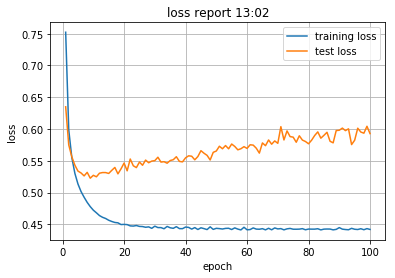

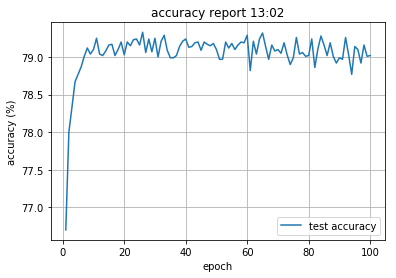

In [53]:
if not os.path.exists('./images/simple_linear/'):
    os.mkdir('./images/simple_linear')
plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='training loss')
plt.plot(list(range(1, len(test_loss) + 1)), test_loss, label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title('loss report {}'.format(datetime.datetime.now().strftime('%H:%M')))
plt.savefig('./images/simple_linear/over_fitting_loss.png')
plt.show()

plt.plot(list(range(1, len(test_correct) + 1)), list(np.asarray(test_correct) / 100.0), label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.grid()
plt.legend()
plt.title('accuracy report {}'.format(datetime.datetime.now().strftime('%H:%M')))
plt.savefig('./images/simple_linear/over_fitting_accuracy.png')
plt.show()

In [54]:
model = SimpleLinear()
optimizer = optim.Adam(model.parameters())
train_loss, test_loss, test_accuracy = run(100, train, test)
plot_results(train_loss, test_loss, test_accuracy, save=True)

Training started at 2017-05-11, 13:02
Training
epoch: 1 [0/60000 (0%)]	loss:0.506599
Training
epoch: 1 [5000/60000 (8%)]	loss:0.230276
Training
epoch: 1 [10000/60000 (17%)]	loss:0.414470
Training
epoch: 1 [15000/60000 (25%)]	loss:0.690776
Training
epoch: 1 [20000/60000 (33%)]	loss:0.552622
Training
epoch: 1 [25000/60000 (42%)]	loss:0.460523
Training
epoch: 1 [30000/60000 (50%)]	loss:0.644950
Training
epoch: 1 [35000/60000 (58%)]	loss:0.506647
Training
epoch: 1 [40000/60000 (67%)]	loss:0.566297
Training
epoch: 1 [45000/60000 (75%)]	loss:0.276409
Training
epoch: 1 [50000/60000 (83%)]	loss:0.598713
Training
epoch: 1 [55000/60000 (92%)]	loss:0.230459
Test
Average loss: 0.6022,	Accuracy: 7924/10000 (79%)
one epoch takes -6.599659 sec
Training
epoch: 2 [0/60000 (0%)]	loss:0.460521
Training
epoch: 2 [5000/60000 (8%)]	loss:0.369181
Training
epoch: 2 [10000/60000 (17%)]	loss:0.368438
Training
epoch: 2 [15000/60000 (25%)]	loss:0.322368
Training
epoch: 2 [20000/60000 (33%)]	loss:0.460517
Training

path to save loss: ./images/result/loss/2017_05_11_13_18.png


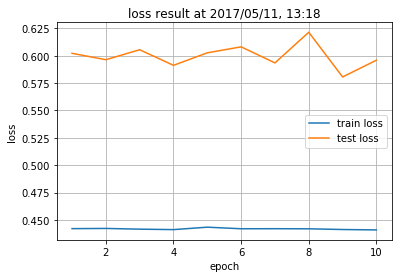

path to save accuracy: ./images/result/accuracy/2017_05_11_13_18.png


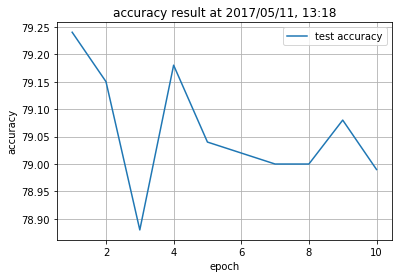

In [74]:
plot_results(train_loss, test_loss, test_accuracy, save=True)

In [80]:
class ComplexLinear(nn.Module):
    
    def __init__(self, in_size=784, hidden_1=256, hidden_2=128, hidden_3=64, out_size=10, dr=True):
        super(ComplexLinear, self).__init__()
        self.dr_flag = dr
        self.fc1 = nn.Linear(in_size, hidden_1)
        if dr:
            self.dr1 = nn.Dropout()
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        if dr:
            self.dr2 = nn.Dropout()
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        if dr:
            self.dr3 = nn.Dropout()
        self.fc4 = nn.Linear(hidden_3, out_size)
    
    def forward(self, x):
        if self.dr_flag:
            h1 = F.relu(self.dr1(self.fc1(x.view(-1, 784))))
            h2 = F.relu(self.dr2(self.fc2(h1)))
            h3 = F.relu(self.dr3(self.fc3(h2)))
        else:
            h1 = F.relu(self.fc1(x.view(-1, 784)))
            h2 = F.relu(self.fc2(h1))
            h3 = F.relu(h2)
        h4 = self.fc4(h3)
        return F.log_softmax(h4)

In [ ]:
# complex model
model = ComplexLinear()
optimizer = optim.Adam(model.parameters())
results = run(100, train, test)
plot_results(*results)

Training started at 2017-05-11, 13:33
Training
epoch: 1 [0/60000 (0%)]	loss:2.318544
Training
epoch: 1 [5000/60000 (8%)]	loss:1.175088
Training
epoch: 1 [10000/60000 (17%)]	loss:0.750134
Training
epoch: 1 [15000/60000 (25%)]	loss:0.570489
Training
epoch: 1 [20000/60000 (33%)]	loss:0.370458
Training
epoch: 1 [25000/60000 (42%)]	loss:0.868578
Training
epoch: 1 [30000/60000 (50%)]	loss:0.367475
Training
epoch: 1 [35000/60000 (58%)]	loss:0.623642
Training
epoch: 1 [40000/60000 (67%)]	loss:0.258727
Training
epoch: 1 [45000/60000 (75%)]	loss:0.496269
Training
epoch: 1 [50000/60000 (83%)]	loss:0.283069
Training
epoch: 1 [55000/60000 (92%)]	loss:0.791455
Test
Average loss: 0.1866,	Accuracy: 9441/10000 (94%)
one epoch takes 9.090794 sec
Training
epoch: 2 [0/60000 (0%)]	loss:0.331482
Training
epoch: 2 [5000/60000 (8%)]	loss:0.408479
Training
epoch: 2 [10000/60000 (17%)]	loss:0.191264
Training
epoch: 2 [15000/60000 (25%)]	loss:0.294274
Training
epoch: 2 [20000/60000 (33%)]	loss:0.140592
Training


Training
epoch: 13 [5000/60000 (8%)]	loss:0.079066
Training
epoch: 13 [10000/60000 (17%)]	loss:0.038373
Training
epoch: 13 [15000/60000 (25%)]	loss:0.065036
Training
epoch: 13 [20000/60000 (33%)]	loss:0.253018
Training
epoch: 13 [25000/60000 (42%)]	loss:0.219679
Training
epoch: 13 [30000/60000 (50%)]	loss:0.444119
Training
epoch: 13 [35000/60000 (58%)]	loss:0.119972
Training
epoch: 13 [40000/60000 (67%)]	loss:0.324075
Training
epoch: 13 [45000/60000 (75%)]	loss:0.023090
Training
epoch: 13 [50000/60000 (83%)]	loss:0.012721
Training
epoch: 13 [55000/60000 (92%)]	loss:0.037957
Test
Average loss: 0.0871,	Accuracy: 9774/10000 (98%)
Training
epoch: 14 [0/60000 (0%)]	loss:0.309822
Training
epoch: 14 [5000/60000 (8%)]	loss:0.189929
Training
epoch: 14 [10000/60000 (17%)]	loss:0.031075
Training
epoch: 14 [15000/60000 (25%)]	loss:0.134466
Training
epoch: 14 [20000/60000 (33%)]	loss:0.124827
Training
epoch: 14 [25000/60000 (42%)]	loss:0.102969
Training
epoch: 14 [30000/60000 (50%)]	loss:0.220196
T

Training
epoch: 25 [5000/60000 (8%)]	loss:0.040177
Training
epoch: 25 [10000/60000 (17%)]	loss:0.101901
Training
epoch: 25 [15000/60000 (25%)]	loss:0.018368
Training
epoch: 25 [20000/60000 (33%)]	loss:0.184705
Training
epoch: 25 [25000/60000 (42%)]	loss:0.011949
Training
epoch: 25 [30000/60000 (50%)]	loss:0.035216
Training
epoch: 25 [35000/60000 (58%)]	loss:0.017852
Training
epoch: 25 [40000/60000 (67%)]	loss:0.142987
Training
epoch: 25 [45000/60000 (75%)]	loss:0.019509
Training
epoch: 25 [50000/60000 (83%)]	loss:0.164835
Training
epoch: 25 [55000/60000 (92%)]	loss:0.073971
Test
Average loss: 0.0820,	Accuracy: 9805/10000 (98%)
Training
epoch: 26 [0/60000 (0%)]	loss:0.007573
Training
epoch: 26 [5000/60000 (8%)]	loss:0.108630
